*Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.
Сделать это предполагается с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы. 
Чтобы определиться с параметрами будущей модели, мы проведём разведывательный анализ данных и оценим результаты этого анализа.* 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
from IPython.display import Markdown, display
import statistics as stat



pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

#Cократим наш stud_math до s_m для удобства
s_m = pd.read_csv('stud_math.xls')

In [2]:
# Определим некоторые вспомогательные функции


def get_Null_percent():
    for col in s_m.columns:
        pct_missing = np.mean(s_m[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))


def paint_Null_heatmap():
    #cols = df.columns[:30] # первые 30 колонок
    # определяем цвета 
    # желтый - пропущенные данные, синий - не пропущенные
    plt.figure(figsize=(16, 10))
    colours = ['#000099', '#ffff00'] 
    printmd('***Желтый цвет означает пропуск в данных.*** \n')
    sns.heatmap(s_m.isnull(), cmap=sns.color_palette(colours),cbar=False)
    
def printmd(string):
    display(Markdown(string))
    
def pr_color_head(string, color=None):
    # 'green', 'blue', 'red', 'yellow'
    #<h1><center>Centered text!</center></h1>
    colorstr = "<h1><center><span style='color:{}'>{}</span></center></h1>".format(color, string)
    display(Markdown(colorstr))    


def q_info(col):
    # quick info - Информация по столбцу
    display(pd.DataFrame(s_m[col].value_counts()))
    s_m.loc[:, [col]].info()


def inter_quant(col):
    # Расчет границ выбросов по межквартильному размаху
    IQR = s_m[col].quantile(0.75) - s_m[col].quantile(0.25)
    perc25 = s_m[col].quantile(0.25)
    perc75 = s_m[col].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))


def to_None(col):
    # Заменяем пустые строки и Nan на None
    s_m[col] = s_m[col].astype(str).apply(
        lambda x: None if (x.strip() == '' or x == 'nan') else x)


def isNan(col):
    # Подсчет количества Nan в столбце col
    for i in s_m[col]:
        if str(i) == 'nan':
            return True
    return False


def pr_column(col, filt_vol=None):
    # Отображает значения в столбце col c опциональной фильтрацией
    counter = 0
    for i in s_m[col]:
        if filt_vol == None:
            print(i, type(i))
            counter += 1
        else:
            if i == filt_vol:
                print(i, type(i))
                counter += 1
    print('Число значений = ', counter)


def get_Null(col, disp=None):
    # Возвращает количество пропусков в столбце col. При любом заданном значении параметра disp отображает DataFrame
    # с пропусками в col.
    null_count = len(s_m[s_m[col].isnull()])
    if disp != None:
        if null_count > 0:
            display(s_m[s_m[col].isnull()])
            print('Количество пустых значений в столбце {} : {}'.format(col, null_count))
        else:
            print('В столце {} нет пропусков данных'.format(col))
    else:
        return null_count


def get_mode(col):
    tp=str(s_m[col].dtype)
    if tp == 'int64':
        return int(s_m[col].mode())
    if tp == 'float64':
        return float(s_m[col].mode())
    return stat.mode(s_m[col])

def get_median(col):
    tp=str(s_m[col].dtype)
    if tp == 'int64':
        return int(s_m[col].median())
    if tp == 'float64':
        return float(s_m[col].median())

def set_null_to_mode(col):
    if get_Null(col) > 0:
        # Заменяет пустые значения в столбце на моду
        # to_None(col) # Уберем пустые строки и Nan
        md=get_mode(col)
        s_m[col] = s_m[col].fillna(md)
        print('Пропуски в столбце {} заменены на моду {}  . После замены осталось пропусков : {} '.format(col,md,get_Null(col)))
    else:
        print('Замена на моду : в столбце {} пропусков данных не обнаружено.'.format(col))
        
sntmod=set_null_to_mode
        
def set_null_to_median(col):
    # Заменяет пустые значения в столбце на медиану
    if get_Null(col) > 0:
        md=get_median(col)
        s_m[col] = s_m[col].fillna(md)
        print('Пропуски в столбце {} заменены на значение медианы {}  . После замены осталось пропусков : {} '.format(col,md,get_Null(col)))
    else:
        print('Замена на медиану : в столбце {} пропусков данных не обнаружено.'.format(col))

sntmed=set_null_to_median

def set_outliers_up_to_median(col,ubound):
    #Заменяем выбросы вверх медианным значением
    md=get_median(col)
    s_m.at[s_m[s_m[col]>ubound].index,[col]]=md
    print('Выбросы вверх (больше {}) в столбце {} заменены на значение медианы {} '.format(ubound,col,md))
    
soupmed=set_outliers_up_to_median

def set_outliers_dawn_to_median(col,lbound):
    #Заменяем выбросы вниз медианным значением
    md=get_median(col)
    s_m.at[s_m[s_m[col]<lbound].index,[col]]=md
    print('Выбросы вниз (меньше {}) в столбце {} заменены на значение медианы {} '.format(lbound,col,md))
    
sodnmed=set_outliers_dawn_to_median


def look_at(col, hst=None):
    # Первичная оценка столбца col
    # При передаче любого значения hst - строим гистограмму
    #nonlocal s_m
    pr_color_head('Cтолбец {}\n'.format(col),color='red')
    display(s_m[col])
    printmd('***------------------Описание {} --------------------------------------------------***\n'.format(col))
    display(s_m[col].describe())
    printmd('***------------------Краткая информация по {} -------------------------------------***\n'.format(col))
    q_info(col)
    printmd('***------------------Пропуски в данных в {} ---------------------------------------***\n'.format(col))
    space_data=get_Null(col, 1) # Запоминаем количество пропусков в данных столбца
    
    # Для метрических переменных
    
    if str(s_m[col].dtype) == 'int64' or str(s_m[col].dtype) == 'float64':
        printmd('\n***--------------Определим наличие выбросов в данных с помощью IQR в {} -------***\n'.format(col))
        IQR = s_m[col].quantile(0.75) - s_m[col].quantile(0.25)
        perc25 = s_m[col].quantile(0.25)
        perc75 = s_m[col].quantile(0.75)
        f = perc25 - 1.5*IQR
        l = perc75 + 1.5*IQR
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
              "IQR: {}, ".format(IQR), "Границы выбросов: [{}, {}].".format(f, l))
        printmd('\n***--------------Выбросы в {} вниз  -------------------------------------------***\n'.format(col))
        outliers_down = len(s_m[s_m[col] < f])
        print('В данных столбца {} выбросов вниз : {}'.format(col, outliers_down))
        if outliers_down > 0:
            display(s_m[s_m[col] < f])
        printmd('\n***--------------Выбросы в {} вверх  ------------------------------------------***\n'.format(col))
        outliers_up = len(s_m[s_m[col] > l])
        print('В данных столбца {} выбросов вверх : {}'.format(col, outliers_up))
        if outliers_up > 0:
            display(s_m[s_m[col] > l])
        if hst != None:
            print('\n\n\n')
            s_m[col].hist(bins=len(s_m[col].value_counts()))
    
    # Для объектов (пока у нас только строки). Пока не включаем этот код, чтобы проверяющим не было нужды отвечать на вопрос
    # меняем пока вручную
    #else:
    #    if space_data > 0 : # Если есть пропуски - предлагаем замнить
    #        strquest='Заменить в столбце {} пустые строки и Nan на None (Y/N) ? : '.format(col)
    #        answer = input(strquest) 
    #        if answer == "y" or answer == "Y" or answer == "Н" or answer == "н": # Русскую раскладку учитываем
    #            to_None(col)
    #            print('Пустые строки и Nan в столбце {} изменены на None.'.format(col))
    #        elif answer == "N" or answer == "n" or answer == "т" or answer == "Т" :
    #            print('Столбец {} не изменен.'.format(col))
            
     
        
def get_boxplot(col):
    u_data=len(s_m[col].unique())
    print(u_data)
    if u_data < 4 : 
        y_size=4
    elif u_data < 6:
        y_size=6
    else:
        y_size=10
        
    fig, ax = plt.subplots(figsize = (y_size, 5))
    sns.boxplot(x=col, y='score', 
                data=s_m.loc[:col],
               ax=ax) # Обращаем внимание на отбор первых 10 строк в дотасете в определенном столбце ! Учимся !
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()
    

def get_stat_dif(column):
    cols = s_m.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(s_m.loc[s_m.loc[:, column] == comb[0], 'score'], 
                        s_m.loc[s_m.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            printmd('**Найдены статистически значимые различия для колонки {}**'.format(column))
            break
    else:
        print('Тест Стьюдента дла {} закончен .'.format(column))

***Желтый цвет означает пропуск в данных.*** 


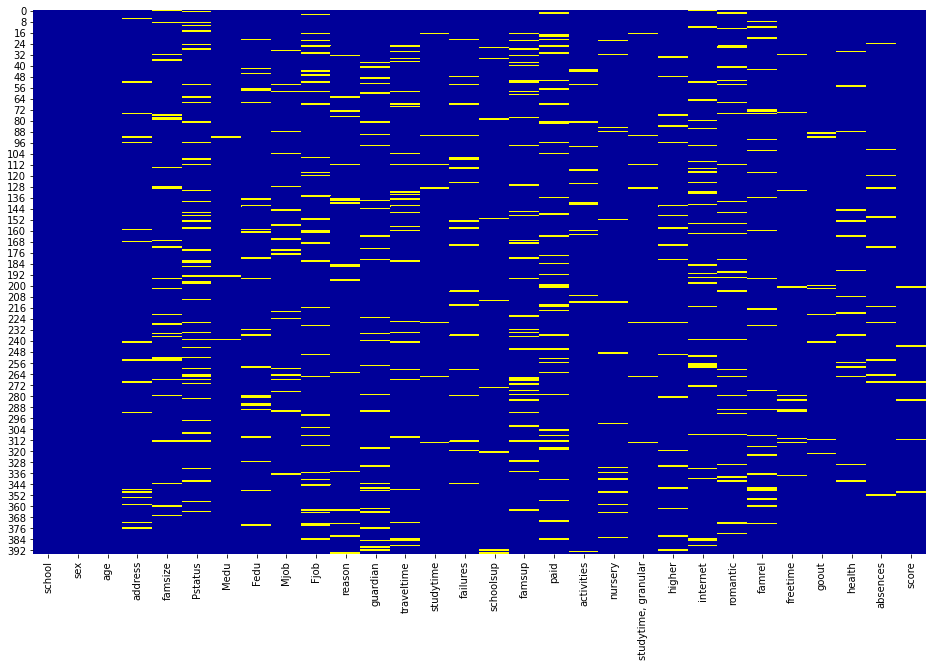

In [3]:
# Проверим наши данные на наличие пропусков
paint_Null_heatmap()

*В данных довольно много пропусков, поэтому удаление строк с пропусками означает потерю большого количества данных.
Вместо удаления будем заменять пропуски на моду, либо медианное значение, в зависимости от типа переменной в столбце.*

In [4]:
s_m.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [5]:
# Приведем наименование столбцов к единому формату
s_m=s_m.rename(columns={'Pstatus' : 'pstatus', 'Medu' : 'medu','Fedu' : 'fedu','Mjob' : 'mjob','Fjob' : 'fjob','studytime, granular' : 'studytime_gran'})

In [6]:
s_m

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


In [7]:
s_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   school          395 non-null    object 
 1   sex             395 non-null    object 
 2   age             395 non-null    int64  
 3   address         378 non-null    object 
 4   famsize         368 non-null    object 
 5   pstatus         350 non-null    object 
 6   medu            392 non-null    float64
 7   fedu            371 non-null    float64
 8   mjob            376 non-null    object 
 9   fjob            359 non-null    object 
 10  reason          378 non-null    object 
 11  guardian        364 non-null    object 
 12  traveltime      367 non-null    float64
 13  studytime       388 non-null    float64
 14  failures        373 non-null    float64
 15  schoolsup       386 non-null    object 
 16  famsup          356 non-null    object 
 17  paid            355 non-null    obj

In [8]:
s_m.describe()

,age,medu,fedu,traveltime,studytime,failures,studytime_gran,famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


In [9]:
look_at('school') # Столбец аббревиатуры школы

<h1><center><span style='color:red'>Cтолбец school
</span></center></h1>

0      GP
1      GP
2      GP
3      GP
4      GP
       ..
390    MS
391    MS
392    MS
393    MS
394    MS
Name: school, Length: 395, dtype: object

***------------------Описание school --------------------------------------------------***


count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

***------------------Краткая информация по school -------------------------------------***


,school
GP,349
MS,46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в school ---------------------------------------***


В столце school нет пропусков данных


*В столбце **school** пустых значений нет. Количество уникальных значений корректно.Видно, что в опросе учавствовали ученики только двух школ. Большинство опрошенных учеников учится в GP*


In [10]:
look_at('sex') # Пол учащегося

<h1><center><span style='color:red'>Cтолбец sex
</span></center></h1>

0      F
1      F
2      F
3      F
4      F
      ..
390    M
391    M
392    M
393    M
394    M
Name: sex, Length: 395, dtype: object

***------------------Описание sex --------------------------------------------------***


count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

***------------------Краткая информация по sex -------------------------------------***


,sex
F,208
M,187


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в sex ---------------------------------------***


В столце sex нет пропусков данных


*Стобец **sex** тоже не требует каких-либо действий. Пропусков нет  и значения корректны.*

<h1><center><span style='color:red'>Cтолбец age
</span></center></h1>

0      18
1      17
2      15
3      15
4      16
       ..
390    20
391    17
392    21
393    18
394    19
Name: age, Length: 395, dtype: int64

***------------------Описание age --------------------------------------------------***


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

***------------------Краткая информация по age -------------------------------------***


,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     395 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


***------------------Пропуски в данных в age ---------------------------------------***


В столце age нет пропусков данных



***--------------Определим наличие выбросов в данных с помощью IQR в age -------***


25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].



***--------------Выбросы в age вниз  -------------------------------------------***


В данных столбца age выбросов вниз : 0



***--------------Выбросы в age вверх  ------------------------------------------***


В данных столбца age выбросов вверх : 1


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
247,GP,M,22,U,GT3,T,3.0,1.0,services,services,other,mother,1.0,1.0,3.0,no,no,no,no,no,-3.0,no,yes,yes,5.0,4.0,5.0,1.0,16.0,40.0


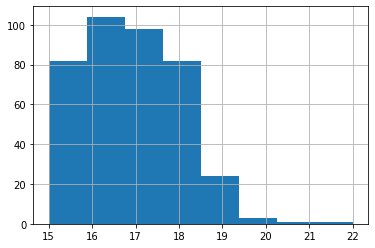

In [11]:
look_at('age',hst=True) # Возраст учащегося 

*В столбце **age** также отсутствуют пропуски.Учеников возраста 20+ совсем немного. Возраст 21 год - граница за которой данные можно считать выбросом по методу IQR. В то же время, возраст 22 года попадает в диапазон возрастов в опросе. Возможно, есть ученик в возрасте 22 года.*  

In [12]:
look_at('address') # Тип адреса

<h1><center><span style='color:red'>Cтолбец address
</span></center></h1>

0      U
1      U
2      U
3      U
4      U
      ..
390    U
391    U
392    R
393    R
394    U
Name: address, Length: 395, dtype: object

***------------------Описание address --------------------------------------------------***


count     378
unique      2
top         U
freq      295
Name: address, dtype: object

***------------------Краткая информация по address -------------------------------------***


,address
U,295
R,83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в address ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,-3.0,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
96,GP,M,16,NaN,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,-3.0,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
168,GP,F,16,NaN,GT3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,no,5.0,1.0,5.0,4.0,0.0,0.0
241,GP,M,17,NaN,LE3,A,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,3.0,3.0,NaN,4.0,2.0,60.0
254,GP,M,17,NaN,NaN,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0
270,GP,F,19,NaN,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,5.0,5.0,NaN,NaN


Количество пустых значений в столбце address : 17


*В столбце ***address*** количество уникальных значений корректно, есть 17 пустых значений. Их удаление считаю ненужным, т.к. мы потеряем значительную часть данных.
Возможно, в нашей будущей модели пропуски будут недопустимы - заменим эти значения на моду. Большинство учеников живет в городе.*

In [13]:
get_mode('address')

'U'

In [14]:
set_null_to_mode('address') # Заменим пустые значения на моду.

Пропуски в столбце address заменены на моду U  . После замены осталось пропусков : 0 


In [15]:
look_at('famsize')

<h1><center><span style='color:red'>Cтолбец famsize
</span></center></h1>

0      NaN
1      GT3
2      LE3
3      GT3
4      GT3
      ... 
390    LE3
391    LE3
392    GT3
393    LE3
394    LE3
Name: famsize, Length: 395, dtype: object

***------------------Описание famsize --------------------------------------------------***


count     368
unique      2
top       GT3
freq      261
Name: famsize, dtype: object

***------------------Краткая информация по famsize -------------------------------------***


,famsize
GT3,261
LE3,107


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в famsize ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0
32,GP,M,15,R,NaN,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,-6.0,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0
36,GP,M,15,U,NaN,T,4.0,3.0,teacher,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,4.0,3.0,4.0,2.0,90.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
78,GP,M,17,U,NaN,T,2.0,1.0,other,other,home,mother,2.0,1.0,3.0,yes,NaN,no,yes,yes,-3.0,no,yes,no,4.0,5.0,1.0,3.0,2.0,50.0
79,GP,F,16,U,NaN,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,-6.0,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
114,GP,M,15,R,NaN,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,no,no,no,yes,yes,-6.0,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0


Количество пустых значений в столбце famsize : 27


In [16]:
get_mode('famsize')

'GT3'

*Столбец **famsize**.Количество уникальных значений корректно.Исходя из значений - в большинстве семей больше одного ребенка. Заменяем пропуски на моду.*

In [17]:
set_null_to_mode('famsize')

Пропуски в столбце famsize заменены на моду GT3  . После замены осталось пропусков : 0 


In [18]:
look_at('pstatus') # Статус совместного проживание родителей

<h1><center><span style='color:red'>Cтолбец pstatus
</span></center></h1>

0        A
1      NaN
2        T
3        T
4        T
      ... 
390      A
391      T
392      T
393      T
394      T
Name: pstatus, Length: 395, dtype: object

***------------------Описание pstatus --------------------------------------------------***


count     350
unique      2
top         T
freq      314
Name: pstatus, dtype: object

***------------------Краткая информация по pstatus -------------------------------------***


,pstatus
T,314
A,36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pstatus  350 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в pstatus ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
9,GP,M,15,U,GT3,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0
15,GP,F,16,U,GT3,NaN,4.0,4.0,health,other,home,mother,1.0,1.0,0.0,no,yes,no,no,yes,-3.0,yes,yes,no,4.0,4.0,4.0,2.0,4.0,70.0
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0
28,GP,M,16,U,LE3,NaN,3.0,4.0,services,other,home,mother,1.0,2.0,0.0,yes,NaN,no,yes,yes,-6.0,yes,yes,no,5.0,3.0,3.0,5.0,4.0,55.0
54,GP,F,15,U,LE3,NaN,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,-3.0,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
63,GP,F,16,U,GT3,NaN,4.0,3.0,teacher,health,NaN,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,-9.0,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
81,GP,M,15,U,GT3,NaN,2.0,3.0,other,other,home,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,-9.0,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0


Количество пустых значений в столбце pstatus : 45


In [19]:
set_null_to_mode('pstatus')

Пропуски в столбце pstatus заменены на моду T  . После замены осталось пропусков : 0 


*Столбец ***pstatus***.Количество уникальных значений корректно.Подавляющее число семей - полные.*

<h1><center><span style='color:red'>Cтолбец medu
</span></center></h1>

0      4.0
1      1.0
2      1.0
3      4.0
4      3.0
      ... 
390    2.0
391    3.0
392    1.0
393    3.0
394    1.0
Name: medu, Length: 395, dtype: float64

***------------------Описание medu --------------------------------------------------***


count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

***------------------Краткая информация по medu -------------------------------------***


,medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   medu    392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


***------------------Пропуски в данных в medu ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
92,GP,F,16,U,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
193,GP,M,16,R,GT3,T,NaN,3.0,services,services,reputation,mother,1.0,1.0,0.0,no,yes,no,yes,yes,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,8.0,50.0
239,GP,M,18,U,GT3,T,NaN,2.0,other,services,reputation,father,1.0,2.0,1.0,no,no,no,no,yes,-6.0,no,NaN,NaN,5.0,5.0,4.0,2.0,0.0,0.0


Количество пустых значений в столбце medu : 3



***--------------Определим наличие выбросов в данных с помощью IQR в medu -------***


25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].



***--------------Выбросы в medu вниз  -------------------------------------------***


В данных столбца medu выбросов вниз : 0



***--------------Выбросы в medu вверх  ------------------------------------------***


В данных столбца medu выбросов вверх : 0






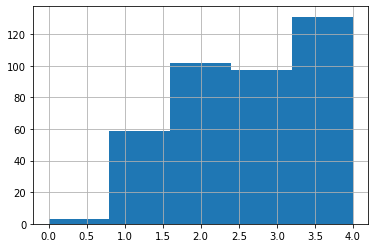

In [20]:
look_at('medu',True) # Образование матери 

In [21]:
set_null_to_mode('medu')

Пропуски в столбце medu заменены на моду 4.0  . После замены осталось пропусков : 0 


*Столбец **medu**. Количество уникальных значений корректно. Есть 3 пропуска в данных, которые мы заменили на моду, т.к. переменная ранговая.Из анализа данных видно, что необразованных матерей почти нет, а количество матерей с высшим образованием велико. Все пропуски данных из GP.*

<h1><center><span style='color:red'>Cтолбец fedu
</span></center></h1>

0      4.0
1      1.0
2      1.0
3      2.0
4      3.0
      ... 
390    2.0
391    1.0
392    1.0
393    2.0
394    1.0
Name: fedu, Length: 395, dtype: float64

***------------------Описание fedu --------------------------------------------------***


count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: fedu, dtype: float64

***------------------Краткая информация по fedu -------------------------------------***


,fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    371 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


***------------------Пропуски в данных в fedu ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
21,GP,M,15,U,GT3,T,4.0,NaN,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,-3.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
42,GP,M,15,U,GT3,T,4.0,NaN,services,teacher,course,father,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,2.0,90.0
46,GP,F,16,U,LE3,A,3.0,NaN,other,services,home,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,5.0,3.0,12.0,55.0
57,GP,M,15,U,GT3,T,4.0,NaN,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0
58,GP,M,15,U,LE3,T,1.0,NaN,other,at_home,home,father,1.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,2.0,5.0,2.0,45.0
67,GP,F,16,U,GT3,T,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
142,GP,F,15,U,GT3,T,4.0,NaN,teacher,services,course,mother,NaN,3.0,0.0,no,yes,yes,yes,yes,-9.0,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
159,GP,M,16,U,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
161,GP,M,15,R,GT3,T,3.0,NaN,other,NaN,course,mother,2.0,2.0,2.0,yes,yes,no,no,yes,-6.0,yes,yes,yes,4.0,4.0,4.0,3.0,6.0,35.0


Количество пустых значений в столбце fedu : 24



***--------------Определим наличие выбросов в данных с помощью IQR в fedu -------***


25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].



***--------------Выбросы в fedu вниз  -------------------------------------------***


В данных столбца fedu выбросов вниз : 2


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
76,GP,M,15,U,GT3,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
171,GP,M,16,U,GT3,T,1.0,0.0,other,other,reputation,mother,2.0,2.0,NaN,no,yes,yes,yes,yes,-6.0,NaN,yes,yes,4.0,3.0,2.0,3.0,2.0,80.0



***--------------Выбросы в fedu вверх  ------------------------------------------***


В данных столбца fedu выбросов вверх : 1


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,T,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


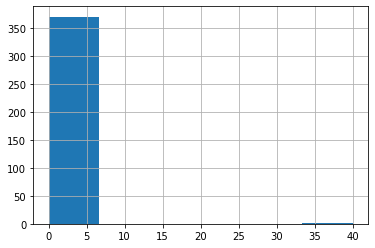

In [22]:
look_at('fedu',True) # Образование отца 

<AxesSubplot:>

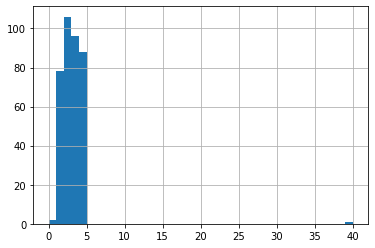

In [23]:
s_m.fedu.hist(bins=40)

In [24]:
# Значение верхнего выброса равно 40. Можно предположить, что вместо 4.0 ввели 40. 
s_m.loc[11,'fedu']

40.0

In [25]:
s_m.loc[11,'fedu']=4

In [26]:
set_null_to_mode('fedu')

Пропуски в столбце fedu заменены на моду 2.0  . После замены осталось пропусков : 0 


<AxesSubplot:>

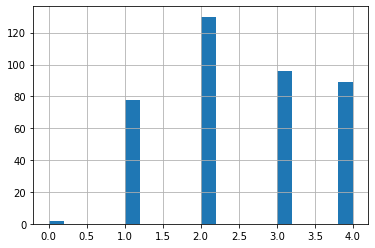

In [27]:
s_m.fedu.hist(bins=20)

*Столбец **fedu**.Количество уникальных значений корректно.Значения 0 не считаем выбросами, т.к. они попадают в заданный диапазон возможных значений.Можно предположить, что значение 40 - это 4.0 с опечаткой.* *Согласно **fedu**, матери образованнее отцов в данном датасете.* 

In [28]:
look_at('mjob') #работа матери

<h1><center><span style='color:red'>Cтолбец mjob
</span></center></h1>

0       at_home
1       at_home
2       at_home
3        health
4         other
         ...   
390    services
391    services
392       other
393    services
394       other
Name: mjob, Length: 395, dtype: object

***------------------Описание mjob --------------------------------------------------***


count       376
unique        5
top       other
freq        133
Name: mjob, dtype: object

***------------------Краткая информация по mjob -------------------------------------***


,mjob
other,133
services,98
at_home,58
teacher,55
health,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    376 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в mjob ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
29,GP,M,16,U,GT3,T,4.0,4.0,NaN,teacher,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,yes,4.0,4.0,5.0,5.0,16.0,55.0
54,GP,F,15,U,LE3,T,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,-3.0,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,-6.0,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
88,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,reputation,father,2.0,2.0,1.0,no,no,yes,yes,NaN,-6.0,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0
104,GP,M,15,U,GT3,A,3.0,4.0,NaN,other,course,mother,NaN,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,yes,no,5.0,4.0,4.0,1.0,0.0,90.0
128,GP,M,18,R,GT3,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
145,GP,F,15,U,GT3,T,1.0,1.0,NaN,services,course,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,4.0,4.0,2.0,NaN,0.0,55.0
156,GP,M,17,R,LE3,T,1.0,2.0,NaN,other,reputation,mother,1.0,1.0,0.0,no,no,no,no,yes,-3.0,yes,no,no,2.0,2.0,2.0,5.0,8.0,65.0
166,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,course,father,1.0,2.0,0.0,no,no,no,no,yes,-6.0,no,yes,no,4.0,3.0,5.0,4.0,4.0,50.0
174,GP,F,16,U,LE3,T,3.0,3.0,NaN,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,4.0,5.0,4.0,4.0,45.0


Количество пустых значений в столбце mjob : 19


In [29]:
# Заменяем пропуски в mjob
set_null_to_mode('mjob')

Пропуски в столбце mjob заменены на моду other  . После замены осталось пропусков : 0 


*Столбец **mjob**.Количество уникальных значений корректно.Все пропуски из GP*

In [30]:
look_at('fjob') # работа отца

<h1><center><span style='color:red'>Cтолбец fjob
</span></center></h1>

0       teacher
1         other
2         other
3           NaN
4         other
         ...   
390    services
391    services
392       other
393       other
394     at_home
Name: fjob, Length: 395, dtype: object

***------------------Описание fjob --------------------------------------------------***


count       359
unique        5
top       other
freq        197
Name: fjob, dtype: object

***------------------Краткая информация по fjob -------------------------------------***


,fjob
other,197
services,102
teacher,29
at_home,16
health,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fjob    359 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в fjob ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,NaN,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,NaN,course,mother,1.0,2.0,0.0,no,NaN,no,yes,NaN,-6.0,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0
26,GP,M,15,U,GT3,T,2.0,2.0,other,NaN,home,mother,NaN,1.0,0.0,no,yes,NaN,no,yes,-3.0,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
31,GP,M,15,U,GT3,T,4.0,4.0,services,NaN,reputation,mother,2.0,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,yes,no,4.0,3.0,1.0,5.0,0.0,85.0
44,GP,F,16,U,LE3,T,2.0,2.0,other,NaN,course,father,2.0,2.0,1.0,yes,no,no,NaN,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,14.0,45.0
47,GP,M,16,U,GT3,T,4.0,3.0,health,NaN,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0
52,GP,M,15,U,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,-3.0,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
59,GP,F,16,U,GT3,T,4.0,2.0,other,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,-6.0,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0


Количество пустых значений в столбце fjob : 36


In [31]:
# Заменим пропуски в данных
sntmod('fjob')

Пропуски в столбце fjob заменены на моду other  . После замены осталось пропусков : 0 


*Столбец **fjob**. Количество уникальных значений корректно.Безработных матерей незначительно больше, чем отцов.*

In [32]:
look_at('reason') # причина выбора школы

<h1><center><span style='color:red'>Cтолбец reason
</span></center></h1>

0      course
1      course
2       other
3        home
4        home
        ...  
390    course
391    course
392    course
393    course
394       NaN
Name: reason, Length: 395, dtype: object

***------------------Описание reason --------------------------------------------------***


count        378
unique         4
top       course
freq         137
Name: reason, dtype: object

***------------------Краткая информация по reason -------------------------------------***


,reason
course,137
home,104
reputation,103
other,34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в reason ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
33,GP,M,15,U,LE3,T,3.0,3.0,other,other,NaN,mother,1.0,2.0,0.0,no,NaN,no,yes,no,-6.0,yes,yes,no,5.0,3.0,2.0,2.0,0.0,60.0
63,GP,F,16,U,GT3,T,4.0,3.0,teacher,health,NaN,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,-9.0,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0
73,GP,M,16,U,GT3,T,3.0,1.0,other,other,NaN,mother,1.0,1.0,0.0,no,no,no,yes,yes,-3.0,yes,no,no,NaN,3.0,2.0,5.0,2.0,70.0
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,NaN,mother,1.0,4.0,0.0,no,no,yes,no,yes,-12.0,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0
112,GP,F,16,U,GT3,T,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
137,GP,F,16,U,GT3,A,3.0,2.0,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
138,GP,M,16,U,LE3,T,1.0,1.0,services,other,NaN,NaN,1.0,2.0,1.0,no,no,no,no,yes,-6.0,yes,no,yes,4.0,4.0,4.0,5.0,0.0,60.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,-12.0,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
185,GP,M,17,U,GT3,T,3.0,3.0,services,services,NaN,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,NaN,yes,4.0,3.0,4.0,4.0,12.0,55.0
186,GP,M,16,U,GT3,T,1.0,2.0,services,services,NaN,mother,1.0,1.0,0.0,no,yes,yes,yes,yes,-3.0,yes,yes,yes,3.0,3.0,3.0,3.0,2.0,55.0


Количество пустых значений в столбце reason : 17


In [33]:
# Заменим  пропуски данных 
sntmod('reason')

Пропуски в столбце reason заменены на моду course  . После замены осталось пропусков : 0 


*Столбец **reason**. Количество уникальных значений корректно.**Reason** показывает, что людям нравится эта школа вообще и образовательная программа, в частности :).* 

In [34]:
look_at('guardian') # опекун . Кто это ?

<h1><center><span style='color:red'>Cтолбец guardian
</span></center></h1>

0      mother
1      father
2      mother
3      mother
4      father
        ...  
390       NaN
391    mother
392       NaN
393    mother
394    father
Name: guardian, Length: 395, dtype: object

***------------------Описание guardian --------------------------------------------------***


count        364
unique         3
top       mother
freq         250
Name: guardian, dtype: object

***------------------Краткая информация по guardian -------------------------------------***


,guardian
mother,250
father,86
other,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в guardian ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
38,GP,F,15,R,GT3,T,3.0,4.0,services,health,course,NaN,1.0,3.0,0.0,yes,NaN,yes,yes,yes,-9.0,yes,yes,no,4.0,3.0,2.0,5.0,2.0,55.0
41,GP,M,15,U,LE3,T,4.0,4.0,teacher,other,home,NaN,1.0,1.0,0.0,no,yes,no,no,no,-3.0,yes,yes,NaN,5.0,4.0,3.0,5.0,8.0,60.0
49,GP,F,15,U,GT3,T,4.0,4.0,services,teacher,other,NaN,1.0,2.0,1.0,yes,yes,no,yes,no,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,2.0,35.0
53,GP,F,15,U,GT3,T,4.0,4.0,services,services,course,NaN,1.0,1.0,0.0,yes,yes,yes,no,yes,-3.0,yes,yes,no,3.0,3.0,4.0,5.0,0.0,55.0
60,GP,F,16,R,GT3,T,4.0,4.0,health,teacher,other,NaN,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,no,no,2.0,4.0,4.0,4.0,6.0,55.0
81,GP,M,15,U,GT3,T,2.0,3.0,other,other,home,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,-9.0,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0
90,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,NaN,1.0,3.0,0.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,3.0,3.0,4.0,0.0,40.0
98,GP,F,16,U,GT3,T,4.0,4.0,other,other,reputation,NaN,1.0,1.0,0.0,no,NaN,no,yes,no,-3.0,yes,NaN,no,5.0,3.0,4.0,1.0,6.0,70.0
138,GP,M,16,U,LE3,T,1.0,1.0,services,other,course,NaN,1.0,2.0,1.0,no,no,no,no,yes,-6.0,yes,no,yes,4.0,4.0,4.0,5.0,0.0,60.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,no,yes,no,no,yes,-3.0,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0


Количество пустых значений в столбце guardian : 31


In [35]:
sntmod('guardian')

Пропуски в столбце guardian заменены на моду mother  . После замены осталось пропусков : 0 


*Столбец **gaurdian**. Количество уникальных значений корректно.Пропусков нет.*

<h1><center><span style='color:red'>Cтолбец traveltime
</span></center></h1>

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
390    1.0
391    2.0
392    1.0
393    3.0
394    1.0
Name: traveltime, Length: 395, dtype: float64

***------------------Описание traveltime --------------------------------------------------***


count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

***------------------Краткая информация по traveltime -------------------------------------***


,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  367 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


***------------------Пропуски в данных в traveltime ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
26,GP,M,15,U,GT3,T,2.0,2.0,other,other,home,mother,NaN,1.0,0.0,no,yes,NaN,no,yes,-3.0,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
30,GP,M,15,U,GT3,T,4.0,4.0,health,services,home,mother,NaN,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,no,5.0,4.0,2.0,NaN,0.0,60.0
35,GP,F,15,U,GT3,T,2.0,3.0,other,other,other,father,NaN,1.0,0.0,NaN,yes,no,yes,yes,-3.0,yes,no,no,3.0,5.0,1.0,5.0,0.0,30.0
37,GP,M,16,R,GT3,A,4.0,4.0,other,teacher,reputation,mother,NaN,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,2.0,4.0,3.0,5.0,7.0,75.0
59,GP,F,16,U,GT3,T,4.0,2.0,other,other,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,-6.0,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,other,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
70,GP,M,16,U,GT3,T,3.0,1.0,other,other,reputation,father,NaN,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
104,GP,M,15,U,GT3,A,3.0,4.0,other,other,course,mother,NaN,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,yes,no,5.0,4.0,4.0,1.0,0.0,90.0
112,GP,F,16,U,GT3,T,2.0,2.0,at_home,other,course,mother,NaN,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
132,GP,F,17,U,LE3,T,2.0,2.0,other,other,course,father,NaN,1.0,0.0,no,yes,no,no,yes,-3.0,yes,NaN,yes,3.0,4.0,4.0,5.0,12.0,60.0


Количество пустых значений в столбце traveltime : 28



***--------------Определим наличие выбросов в данных с помощью IQR в traveltime -------***


25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].



***--------------Выбросы в traveltime вниз  -------------------------------------------***


В данных столбца traveltime выбросов вниз : 0



***--------------Выбросы в traveltime вверх  ------------------------------------------***


В данных столбца traveltime выбросов вверх : 7


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
61,GP,F,16,U,GT3,T,1.0,1.0,services,services,course,father,4.0,1.0,0.0,yes,NaN,no,yes,no,-3.0,yes,yes,yes,5.0,5.0,5.0,5.0,6.0,55.0
108,GP,M,15,R,GT3,T,4.0,4.0,other,other,home,father,4.0,4.0,NaN,no,yes,yes,yes,yes,-12.0,yes,yes,yes,1.0,3.0,5.0,1.0,6.0,65.0
149,GP,M,15,U,LE3,T,2.0,1.0,services,other,course,mother,4.0,1.0,3.0,no,NaN,no,no,yes,-3.0,NaN,yes,no,4.0,5.0,5.0,5.0,0.0,50.0
164,GP,M,17,R,LE3,T,1.0,1.0,other,services,course,mother,4.0,2.0,3.0,no,no,NaN,yes,yes,-6.0,no,no,yes,5.0,3.0,5.0,NaN,0.0,35.0
228,GP,M,18,U,GT3,T,2.0,1.0,at_home,other,course,mother,4.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,yes,4.0,3.0,2.0,3.0,14.0,45.0
327,GP,M,17,R,GT3,T,2.0,2.0,services,other,course,mother,4.0,1.0,0.0,no,NaN,no,no,yes,-3.0,yes,yes,no,4.0,4.0,5.0,4.0,8.0,50.0
375,MS,F,18,R,GT3,T,1.0,1.0,other,other,home,mother,4.0,3.0,0.0,no,no,no,no,yes,-9.0,yes,yes,no,4.0,3.0,2.0,4.0,2.0,50.0


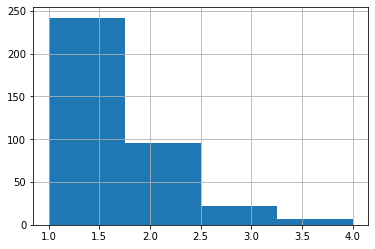

In [36]:
look_at('traveltime',True) # время в пути до школы

In [37]:
sntmod('traveltime')

Пропуски в столбце traveltime заменены на моду 1.0  . После замены осталось пропусков : 0 


*Столбец **traveltime**. Количество уникальных значений корректно.Значения столбца **traveltime**, равные 4 - не считаем выбросами, т.к. они входят в диапазон возможных значений. Подавляющее большинство учеников живет не более, чем в 30 минутах пути от школы.*

<h1><center><span style='color:red'>Cтолбец studytime
</span></center></h1>

0      2.0
1      2.0
2      2.0
3      3.0
4      2.0
      ... 
390    2.0
391    1.0
392    1.0
393    1.0
394    1.0
Name: studytime, Length: 395, dtype: float64

***------------------Описание studytime --------------------------------------------------***


count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

***------------------Краткая информация по studytime -------------------------------------***


,studytime
2.0,194
1.0,103
3.0,64
4.0,27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  388 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


***------------------Пропуски в данных в studytime ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
17,GP,F,16,U,GT3,T,3.0,3.0,other,other,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,NaN,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,NaN,NaN,no,no,yes,yes,yes,NaN,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
112,GP,F,16,U,GT3,T,2.0,2.0,at_home,other,course,mother,1.0,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
129,GP,M,16,R,GT3,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0
227,GP,M,17,U,LE3,T,2.0,3.0,services,services,reputation,father,1.0,NaN,0.0,no,yes,yes,no,no,NaN,NaN,yes,no,5.0,3.0,3.0,3.0,NaN,60.0
266,GP,M,17,U,GT3,T,3.0,1.0,services,other,other,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,NaN,5.0,4.0,4.0,NaN,2.0,50.0
314,GP,F,19,U,GT3,T,1.0,1.0,at_home,health,home,other,1.0,NaN,2.0,no,no,no,no,no,NaN,yes,yes,yes,4.0,NaN,2.0,3.0,14.0,65.0


Количество пустых значений в столбце studytime : 7



***--------------Определим наличие выбросов в данных с помощью IQR в studytime -------***


25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].



***--------------Выбросы в studytime вниз  -------------------------------------------***


В данных столбца studytime выбросов вниз : 0



***--------------Выбросы в studytime вверх  ------------------------------------------***


В данных столбца studytime выбросов вверх : 27


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
47,GP,M,16,U,GT3,T,4.0,3.0,health,other,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0
66,GP,M,15,U,GT3,A,4.0,4.0,other,services,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,no,-12.0,yes,yes,yes,1.0,3.0,3.0,3.0,4.0,60.0
67,GP,F,16,U,GT3,T,3.0,2.0,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
69,GP,F,15,R,LE3,T,3.0,1.0,other,other,reputation,father,2.0,4.0,0.0,no,yes,no,no,no,-12.0,yes,yes,no,4.0,4.0,2.0,3.0,12.0,80.0
70,GP,M,16,U,GT3,T,3.0,1.0,other,other,reputation,father,1.0,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
71,GP,M,15,U,GT3,T,4.0,2.0,other,other,course,mother,1.0,4.0,0.0,no,no,no,no,yes,-12.0,yes,yes,no,3.0,3.0,3.0,3.0,0.0,50.0
76,GP,M,15,U,GT3,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,course,mother,1.0,4.0,0.0,no,no,yes,no,yes,-12.0,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0
94,GP,M,15,U,LE3,T,2.0,2.0,services,health,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,yes,-12.0,yes,yes,no,NaN,3.0,4.0,4.0,6.0,70.0
95,GP,F,15,R,GT3,T,1.0,1.0,at_home,other,home,mother,2.0,4.0,1.0,yes,yes,yes,yes,yes,-12.0,yes,yes,no,3.0,1.0,2.0,1.0,2.0,50.0


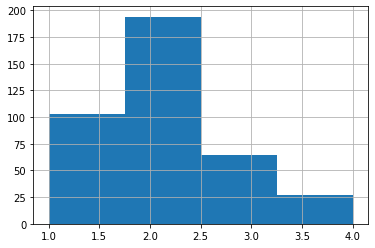

In [38]:
look_at('studytime', True) # время на учёбу помимо школы в неделю

In [39]:
sntmod('studytime')

Пропуски в столбце studytime заменены на моду 2.0  . После замены осталось пропусков : 0 


*Столбец **studytime**. Количество уникальных значений корректно.Значения **studytime** , равные 4 не квалифицируем как выбросы, ибо это значение входит в диапазон корректных значений. 3/4 учащихся тратит на внешкольные занятия меньше 5-ти часов.* 

<h1><center><span style='color:red'>Cтолбец failures
</span></center></h1>

0      0.0
1      0.0
2      3.0
3      0.0
4      0.0
      ... 
390    2.0
391    0.0
392    3.0
393    0.0
394    0.0
Name: failures, Length: 395, dtype: float64

***------------------Описание failures --------------------------------------------------***


count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

***------------------Краткая информация по failures -------------------------------------***


,failures
0.0,293
1.0,49
2.0,16
3.0,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  373 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


***------------------Пропуски в данных в failures ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
21,GP,M,15,U,GT3,T,4.0,2.0,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,-3.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
48,GP,M,15,U,GT3,T,4.0,2.0,teacher,other,home,mother,1.0,2.0,NaN,no,yes,yes,no,yes,-6.0,NaN,no,no,4.0,3.0,3.0,5.0,2.0,70.0
54,GP,F,15,U,LE3,T,3.0,3.0,other,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,-3.0,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,other,reputation,mother,1.0,2.0,NaN,yes,yes,NaN,no,yes,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,NaN,no,no,yes,yes,yes,NaN,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
107,GP,M,16,U,GT3,T,3.0,3.0,services,other,home,father,1.0,3.0,NaN,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,3.0,3.0,5.0,2.0,90.0
108,GP,M,15,R,GT3,T,4.0,4.0,other,other,home,father,4.0,4.0,NaN,no,yes,yes,yes,yes,-12.0,yes,yes,yes,1.0,3.0,5.0,1.0,6.0,65.0
114,GP,M,15,R,GT3,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,no,no,no,yes,yes,-6.0,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0
115,GP,M,16,U,GT3,T,4.0,4.0,teacher,teacher,course,father,1.0,2.0,NaN,no,yes,no,yes,yes,-6.0,yes,NaN,no,5.0,4.0,4.0,5.0,2.0,80.0
125,GP,M,15,U,GT3,T,3.0,4.0,services,services,home,father,1.0,1.0,NaN,yes,no,no,no,yes,-3.0,yes,NaN,no,5.0,5.0,5.0,5.0,0.0,60.0


Количество пустых значений в столбце failures : 22



***--------------Определим наличие выбросов в данных с помощью IQR в failures -------***


25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].



***--------------Выбросы в failures вниз  -------------------------------------------***


В данных столбца failures выбросов вниз : 0



***--------------Выбросы в failures вверх  ------------------------------------------***


В данных столбца failures выбросов вверх : 80


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
18,GP,M,17,U,GT3,T,3.0,2.0,services,services,course,mother,1.0,1.0,3.0,no,yes,NaN,yes,yes,-3.0,yes,yes,no,5.0,5.0,5.0,5.0,16.0,25.0
25,GP,F,16,U,GT3,T,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
44,GP,F,16,U,LE3,T,2.0,2.0,other,other,course,father,2.0,2.0,1.0,yes,no,no,NaN,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,14.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,MS,M,18,R,GT3,T,4.0,2.0,other,other,home,father,1.0,1.0,1.0,no,no,NaN,no,yes,-3.0,yes,NaN,no,5.0,4.0,3.0,3.0,14.0,25.0
387,MS,F,19,R,GT3,T,2.0,3.0,services,other,course,mother,1.0,3.0,1.0,no,no,no,yes,no,-9.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,0.0
389,MS,F,18,U,GT3,T,1.0,1.0,other,other,course,mother,1.0,2.0,1.0,no,no,no,yes,yes,-6.0,yes,NaN,no,1.0,1.0,1.0,5.0,0.0,0.0
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,mother,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0


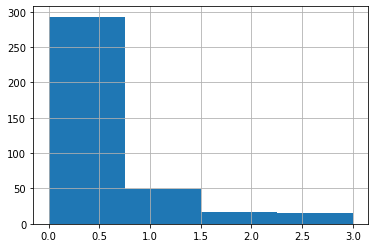

In [40]:
look_at('failures',True) # количество внеучебных неудач. Что это ? :)

In [41]:
sntmod('failures')

Пропуски в столбце failures заменены на моду 0.0  . После замены осталось пропусков : 0 


*Столбец **failures**. Количество уникальных значений корректно.Что такое внеучебные неудачи ? Не очень понятно, однако из **failures** следует, что подавляющее большинство обошлось без них. Все данные в допустимом диапазоне.Выбросы вверх по методу IQR таковыми не считаем, поскольку из описания столбца следует, что максимальное значение равно 3, что допустимо по условиям ,  данные не изменяем.*  

In [42]:
look_at('schoolsup') # дополнительная образовательная поддержка

<h1><center><span style='color:red'>Cтолбец schoolsup
</span></center></h1>

0      yes
1       no
2      yes
3       no
4       no
      ... 
390     no
391     no
392    NaN
393     no
394    NaN
Name: schoolsup, Length: 395, dtype: object

***------------------Описание schoolsup --------------------------------------------------***


count     386
unique      2
top        no
freq      335
Name: schoolsup, dtype: object

***------------------Краткая информация по schoolsup -------------------------------------***


,schoolsup
no,335
yes,51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  386 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в schoolsup ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
27,GP,M,15,U,GT3,T,4.0,2.0,health,services,other,mother,1.0,1.0,0.0,NaN,no,yes,no,yes,-3.0,yes,yes,NaN,2.0,2.0,4.0,1.0,4.0,75.0
35,GP,F,15,U,GT3,T,2.0,3.0,other,other,other,father,1.0,1.0,0.0,NaN,yes,no,yes,yes,-3.0,yes,no,no,3.0,5.0,1.0,5.0,0.0,30.0
79,GP,F,16,U,GT3,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,-6.0,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
151,GP,M,16,U,LE3,T,2.0,1.0,at_home,other,course,mother,1.0,1.0,1.0,NaN,no,no,yes,yes,-3.0,yes,no,yes,4.0,4.0,4.0,5.0,6.0,70.0
211,GP,M,17,U,LE3,T,4.0,4.0,services,other,home,mother,1.0,2.0,0.0,NaN,yes,yes,no,yes,-6.0,yes,yes,yes,5.0,3.0,5.0,3.0,13.0,65.0
274,GP,F,17,U,GT3,T,2.0,4.0,at_home,health,reputation,mother,2.0,2.0,0.0,NaN,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,3.0,3.0,1.0,2.0,50.0
321,GP,F,17,U,GT3,T,2.0,2.0,other,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,-6.0,yes,no,yes,4.0,2.0,2.0,3.0,12.0,45.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,mother,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
394,MS,M,19,U,LE3,T,1.0,1.0,other,at_home,course,father,1.0,1.0,0.0,NaN,no,no,no,yes,-3.0,yes,yes,no,3.0,2.0,3.0,5.0,5.0,45.0


Количество пустых значений в столбце schoolsup : 9


In [43]:
sntmod('schoolsup')

Пропуски в столбце schoolsup заменены на моду no  . После замены осталось пропусков : 0 


*Столбец **schoolsup**. Количество уникальных значений корректно.Как видно из **schoolsup** внеучебную поддержку получают немногие.*

In [44]:
look_at('famsup') # семейная образовательная поддержка

<h1><center><span style='color:red'>Cтолбец famsup
</span></center></h1>

0       no
1      yes
2       no
3      yes
4      yes
      ... 
390    yes
391     no
392     no
393     no
394     no
Name: famsup, Length: 395, dtype: object

***------------------Описание famsup --------------------------------------------------***


count     356
unique      2
top       yes
freq      219
Name: famsup, dtype: object

***------------------Краткая информация по famsup -------------------------------------***


,famsup
yes,219
no,137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в famsup ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
17,GP,F,16,U,GT3,T,3.0,3.0,other,other,reputation,mother,3.0,2.0,0.0,yes,NaN,no,yes,yes,NaN,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,other,course,mother,1.0,2.0,0.0,no,NaN,no,yes,NaN,-6.0,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0
28,GP,M,16,U,LE3,T,3.0,4.0,services,other,home,mother,1.0,2.0,0.0,yes,NaN,no,yes,yes,-6.0,yes,yes,no,5.0,3.0,3.0,5.0,4.0,55.0
33,GP,M,15,U,LE3,T,3.0,3.0,other,other,course,mother,1.0,2.0,0.0,no,NaN,no,yes,no,-6.0,yes,yes,no,5.0,3.0,2.0,2.0,0.0,60.0
38,GP,F,15,R,GT3,T,3.0,4.0,services,health,course,mother,1.0,3.0,0.0,yes,NaN,yes,yes,yes,-9.0,yes,yes,no,4.0,3.0,2.0,5.0,2.0,55.0
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
51,GP,F,15,U,LE3,T,4.0,2.0,health,other,other,mother,1.0,2.0,0.0,no,NaN,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,3.0,5.0,2.0,65.0
52,GP,M,15,U,LE3,A,4.0,2.0,health,other,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,-3.0,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
59,GP,F,16,U,GT3,T,4.0,2.0,other,other,course,mother,1.0,2.0,0.0,no,NaN,no,no,yes,-6.0,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
61,GP,F,16,U,GT3,T,1.0,1.0,services,services,course,father,4.0,1.0,0.0,yes,NaN,no,yes,no,-3.0,yes,yes,yes,5.0,5.0,5.0,5.0,6.0,55.0


Количество пустых значений в столбце famsup : 39


In [45]:
sntmod('famsup')

Пропуски в столбце famsup заменены на моду yes  . После замены осталось пропусков : 0 


*Столбец **famsup**. Количество уникальных значений корректно.Как следует из **famsup**, семейную образовательную поддержку получают более половины учащихся. Почти все пропуски из GP*

In [46]:
look_at('paid') # дополнительные платные занятия по математике

<h1><center><span style='color:red'>Cтолбец paid
</span></center></h1>

0       no
1       no
2      NaN
3      yes
4      yes
      ... 
390    yes
391     no
392     no
393     no
394     no
Name: paid, Length: 395, dtype: object

***------------------Описание paid --------------------------------------------------***


count     355
unique      2
top        no
freq      200
Name: paid, dtype: object

***------------------Краткая информация по paid -------------------------------------***


,paid
no,200
yes,155


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в paid ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
18,GP,M,17,U,GT3,T,3.0,2.0,services,services,course,mother,1.0,1.0,3.0,no,yes,NaN,yes,yes,-3.0,yes,yes,no,5.0,5.0,5.0,5.0,16.0,25.0
19,GP,M,16,U,LE3,T,4.0,3.0,health,other,home,father,1.0,1.0,0.0,no,no,NaN,yes,yes,-3.0,yes,yes,no,3.0,1.0,3.0,5.0,4.0,50.0
21,GP,M,15,U,GT3,T,4.0,2.0,health,health,other,father,1.0,1.0,0.0,no,yes,NaN,no,yes,-3.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
26,GP,M,15,U,GT3,T,2.0,2.0,other,other,home,mother,1.0,1.0,0.0,no,yes,NaN,no,yes,-3.0,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
31,GP,M,15,U,GT3,T,4.0,4.0,services,other,reputation,mother,2.0,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,yes,no,4.0,3.0,1.0,5.0,0.0,85.0
51,GP,F,15,U,LE3,T,4.0,2.0,health,other,other,mother,1.0,2.0,0.0,no,yes,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,3.0,5.0,2.0,65.0
57,GP,M,15,U,GT3,T,4.0,2.0,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,other,reputation,mother,1.0,2.0,0.0,yes,yes,NaN,no,yes,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
81,GP,M,15,U,GT3,T,2.0,3.0,other,other,home,mother,1.0,3.0,0.0,yes,no,NaN,NaN,no,-9.0,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0


Количество пустых значений в столбце paid : 40


In [47]:
sntmod('paid')

Пропуски в столбце paid заменены на моду no  . После замены осталось пропусков : 0 


*Столбец **paid**. Количество уникальных значений корректно. Почти треть детей занимается математикой дополнительно.* 

In [48]:
look_at('activities') # дополнительные внеучебные занятия 

<h1><center><span style='color:red'>Cтолбец activities
</span></center></h1>

0       no
1       no
2       no
3      yes
4       no
      ... 
390     no
391     no
392     no
393    NaN
394     no
Name: activities, Length: 395, dtype: object

***------------------Описание activities --------------------------------------------------***


count     381
unique      2
top       yes
freq      195
Name: activities, dtype: object

***------------------Краткая информация по activities -------------------------------------***


,activities
yes,195
no,186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в activities ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
43,GP,M,15,U,GT3,T,2.0,2.0,services,services,course,father,1.0,1.0,0.0,yes,yes,no,NaN,yes,-3.0,yes,yes,no,NaN,4.0,1.0,1.0,0.0,55.0
44,GP,F,16,U,LE3,T,2.0,2.0,other,other,course,father,2.0,2.0,1.0,yes,no,no,NaN,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,14.0,45.0
54,GP,F,15,U,LE3,T,3.0,3.0,other,other,other,mother,1.0,1.0,0.0,no,no,yes,NaN,yes,-3.0,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
81,GP,M,15,U,GT3,T,2.0,3.0,other,other,home,mother,1.0,3.0,0.0,yes,no,no,NaN,no,-9.0,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0
99,GP,F,16,U,GT3,T,4.0,3.0,other,at_home,course,mother,1.0,3.0,0.0,yes,yes,yes,NaN,yes,-9.0,yes,yes,no,5.0,3.0,5.0,3.0,0.0,40.0
116,GP,M,15,U,GT3,T,4.0,4.0,other,teacher,reputation,father,2.0,2.0,0.0,no,yes,no,NaN,yes,-6.0,yes,no,no,4.0,4.0,3.0,2.0,2.0,70.0
126,GP,F,15,U,LE3,A,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,yes,no,no,NaN,yes,-6.0,yes,yes,yes,5.0,3.0,2.0,1.0,0.0,55.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,course,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,-12.0,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
141,GP,M,16,U,LE3,T,2.0,2.0,services,services,reputation,father,2.0,1.0,2.0,no,yes,no,NaN,yes,-3.0,yes,NaN,no,2.0,3.0,3.0,2.0,8.0,45.0
160,GP,M,17,R,LE3,T,2.0,1.0,at_home,other,course,mother,1.0,1.0,2.0,no,no,no,NaN,yes,-3.0,no,yes,yes,NaN,3.0,2.0,5.0,0.0,0.0


Количество пустых значений в столбце activities : 14


In [49]:
sntmod('activities')

Пропуски в столбце activities заменены на моду yes  . После замены осталось пропусков : 0 


*Столбец **activities**. Количество уникальных значений корректно.Почти половина учеников занимается вне школы.Много.* 

In [50]:
look_at('nursery') # посещал детский сад 

<h1><center><span style='color:red'>Cтолбец nursery
</span></center></h1>

0      yes
1       no
2      yes
3      yes
4      yes
      ... 
390    yes
391     no
392     no
393     no
394    yes
Name: nursery, Length: 395, dtype: object

***------------------Описание nursery --------------------------------------------------***


count     379
unique      2
top       yes
freq      300
Name: nursery, dtype: object

***------------------Краткая информация по nursery -------------------------------------***


,nursery
yes,300
no,79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в nursery ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,other,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,-6.0,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0
32,GP,M,15,R,GT3,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,-6.0,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0
85,GP,F,15,U,GT3,T,4.0,4.0,services,services,reputation,father,2.0,2.0,2.0,no,no,yes,no,NaN,-6.0,yes,yes,yes,4.0,4.0,4.0,5.0,6.0,40.0
88,GP,M,16,U,GT3,T,2.0,2.0,other,other,reputation,father,2.0,2.0,1.0,no,no,yes,yes,NaN,-6.0,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0
152,GP,F,15,R,GT3,T,3.0,3.0,services,other,reputation,other,2.0,3.0,2.0,no,yes,yes,yes,NaN,-9.0,yes,yes,yes,4.0,2.0,1.0,3.0,8.0,50.0
212,GP,F,16,U,GT3,A,2.0,2.0,other,other,reputation,mother,1.0,2.0,0.0,yes,yes,yes,yes,NaN,-6.0,yes,yes,no,3.0,3.0,4.0,4.0,0.0,70.0
249,GP,M,16,U,GT3,T,0.0,2.0,other,other,other,mother,1.0,1.0,0.0,no,no,yes,no,NaN,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
300,GP,F,18,U,LE3,A,4.0,4.0,health,other,home,mother,1.0,2.0,0.0,no,yes,no,no,NaN,-6.0,yes,yes,yes,4.0,2.0,4.0,4.0,14.0,55.0
332,GP,F,18,U,GT3,T,3.0,3.0,services,services,home,mother,1.0,2.0,0.0,no,no,no,yes,NaN,-6.0,yes,yes,no,5.0,3.0,4.0,4.0,0.0,0.0
336,GP,F,19,R,GT3,A,3.0,1.0,services,other,home,other,1.0,3.0,1.0,no,no,yes,no,NaN,-9.0,yes,no,no,5.0,4.0,3.0,5.0,12.0,65.0


Количество пустых значений в столбце nursery : 16


In [51]:
sntmod('nursery')

Пропуски в столбце nursery заменены на моду yes  . После замены осталось пропусков : 0 


*Столбец **nursery**. Количество уникальных значений корректно.Почти все были в детском саду.*

In [52]:
look_at('higher') # хочет получить высшее образование 

<h1><center><span style='color:red'>Cтолбец higher
</span></center></h1>

0      yes
1      yes
2      yes
3      yes
4      yes
      ... 
390    yes
391    yes
392    NaN
393    yes
394    yes
Name: higher, Length: 395, dtype: object

***------------------Описание higher --------------------------------------------------***


count     375
unique      2
top       yes
freq      356
Name: higher, dtype: object

***------------------Краткая информация по higher -------------------------------------***


,higher
yes,356
no,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в higher ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
34,GP,M,16,U,GT3,T,3.0,2.0,other,other,home,mother,1.0,1.0,0.0,no,yes,yes,no,no,-3.0,NaN,yes,no,5.0,4.0,3.0,5.0,0.0,75.0
48,GP,M,15,U,GT3,T,4.0,2.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,NaN,no,no,4.0,3.0,3.0,5.0,2.0,70.0
76,GP,M,15,U,GT3,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
84,GP,F,15,U,GT3,T,1.0,1.0,other,other,home,father,1.0,2.0,0.0,no,yes,no,yes,no,-6.0,NaN,yes,no,4.0,3.0,2.0,4.0,2.0,50.0
96,GP,M,16,U,GT3,T,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,no,yes,no,-3.0,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
142,GP,F,15,U,GT3,T,4.0,2.0,teacher,services,course,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
149,GP,M,15,U,LE3,T,2.0,1.0,services,other,course,mother,4.0,1.0,3.0,no,yes,no,no,yes,-3.0,NaN,yes,no,4.0,5.0,5.0,5.0,0.0,50.0
158,GP,M,16,R,GT3,T,2.0,2.0,at_home,other,course,mother,3.0,1.0,0.0,no,no,no,no,no,-3.0,NaN,no,no,4.0,2.0,2.0,3.0,2.0,75.0
170,GP,M,16,U,GT3,T,3.0,4.0,other,other,course,father,3.0,1.0,0.0,no,yes,no,yes,no,-3.0,NaN,yes,no,3.0,4.0,5.0,2.0,0.0,0.0
171,GP,M,16,U,GT3,T,1.0,0.0,other,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,NaN,yes,yes,4.0,3.0,2.0,3.0,2.0,80.0


Количество пустых значений в столбце higher : 20


In [53]:
sntmod('higher')

Пропуски в столбце higher заменены на моду yes  . После замены осталось пропусков : 0 


*Столбец **higher**. Количество уникальных значений корректно.19 человек не хочет получать высшее образование. Интересно, почему ?*

In [54]:
look_at('internet') # наличие интернета дома 

<h1><center><span style='color:red'>Cтолбец internet
</span></center></h1>

0      NaN
1      yes
2      yes
3      yes
4       no
      ... 
390     no
391    yes
392     no
393    yes
394    yes
Name: internet, Length: 395, dtype: object

***------------------Описание internet --------------------------------------------------***


count     361
unique      2
top       yes
freq      305
Name: internet, dtype: object

***------------------Краткая информация по internet -------------------------------------***


,internet
yes,305
no,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в internet ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
12,GP,M,15,U,LE3,T,4.0,4.0,health,services,course,father,1.0,1.0,0.0,no,yes,yes,yes,yes,-3.0,yes,NaN,no,NaN,3.0,3.0,5.0,2.0,70.0
52,GP,M,15,U,LE3,A,4.0,2.0,health,other,other,father,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
65,GP,F,16,U,LE3,T,4.0,3.0,teacher,services,course,mother,3.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,NaN,no,5.0,4.0,3.0,1.0,2.0,75.0
80,GP,M,15,U,GT3,T,2.0,3.0,other,services,course,father,1.0,1.0,0.0,yes,yes,yes,yes,no,-3.0,yes,NaN,yes,3.0,2.0,2.0,3.0,2.0,60.0
86,GP,F,16,U,LE3,T,2.0,2.0,at_home,other,course,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,2.0,4.0,30.0
98,GP,F,16,U,GT3,T,4.0,4.0,other,other,reputation,mother,1.0,1.0,0.0,no,yes,no,yes,no,-3.0,yes,NaN,no,5.0,3.0,4.0,1.0,6.0,70.0
110,GP,M,15,U,LE3,A,4.0,4.0,teacher,teacher,course,mother,1.0,1.0,0.0,no,no,no,yes,yes,-3.0,yes,NaN,no,5.0,5.0,3.0,4.0,6.0,95.0
115,GP,M,16,U,GT3,T,4.0,4.0,teacher,teacher,course,father,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,NaN,no,5.0,4.0,4.0,5.0,2.0,80.0
117,GP,M,16,U,GT3,T,3.0,3.0,other,services,home,father,2.0,1.0,0.0,no,no,no,yes,yes,-3.0,yes,NaN,no,5.0,4.0,2.0,5.0,0.0,65.0


Количество пустых значений в столбце internet : 34


In [55]:
sntmod('internet')

Пропуски в столбце internet заменены на моду yes  . После замены осталось пропусков : 0 


*Столбец **internet**. Количество уникальных значений корректно.Интернет почти у всех.*

In [56]:
look_at('romantic') # в романтических отношениях

<h1><center><span style='color:red'>Cтолбец romantic
</span></center></h1>

0       no
1       no
2      NaN
3      yes
4       no
      ... 
390     no
391     no
392     no
393     no
394     no
Name: romantic, Length: 395, dtype: object

***------------------Описание romantic --------------------------------------------------***


count     364
unique      2
top        no
freq      240
Name: romantic, dtype: object

***------------------Краткая информация по romantic -------------------------------------***


,romantic
no,240
yes,124


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


***------------------Пропуски в данных в romantic ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,no,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
13,GP,M,15,U,GT3,T,4.0,3.0,teacher,other,course,mother,2.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,NaN,5.0,4.0,3.0,3.0,2.0,55.0
26,GP,M,15,U,GT3,T,2.0,2.0,other,other,home,mother,1.0,1.0,0.0,no,yes,no,no,yes,-3.0,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
27,GP,M,15,U,GT3,T,4.0,2.0,health,services,other,mother,1.0,1.0,0.0,no,no,yes,no,yes,-3.0,yes,yes,NaN,2.0,2.0,4.0,1.0,4.0,75.0
41,GP,M,15,U,LE3,T,4.0,4.0,teacher,other,home,mother,1.0,1.0,0.0,no,yes,no,no,no,-3.0,yes,yes,NaN,5.0,4.0,3.0,5.0,8.0,60.0
51,GP,F,15,U,LE3,T,4.0,2.0,health,other,other,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,yes,NaN,4.0,3.0,3.0,5.0,2.0,65.0
54,GP,F,15,U,LE3,T,3.0,3.0,other,other,other,mother,1.0,1.0,0.0,no,no,yes,yes,yes,-3.0,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
67,GP,F,16,U,GT3,T,3.0,2.0,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
75,GP,M,15,U,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
112,GP,F,16,U,GT3,T,2.0,2.0,at_home,other,course,mother,1.0,2.0,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0


Количество пустых значений в столбце romantic : 31


In [57]:
sntmod('romantic')

Пропуски в столбце romantic заменены на моду no  . После замены осталось пропусков : 0 


*Столбец **romantic**. Количество уникальных значений корректно. 2/3-ям учащихся не до раматники.*

In [58]:
look_at('famrel') # семейные отношения 

<h1><center><span style='color:red'>Cтолбец famrel
</span></center></h1>

0      4.0
1      5.0
2      4.0
3      3.0
4      4.0
      ... 
390    5.0
391    2.0
392    5.0
393    4.0
394    3.0
Name: famrel, Length: 395, dtype: float64

***------------------Описание famrel --------------------------------------------------***


count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

***------------------Краткая информация по famrel -------------------------------------***


,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  368 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


***------------------Пропуски в данных в famrel ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
12,GP,M,15,U,LE3,T,4.0,4.0,health,services,course,father,1.0,1.0,0.0,no,yes,yes,yes,yes,-3.0,yes,yes,no,NaN,3.0,3.0,5.0,2.0,70.0
20,GP,M,15,U,GT3,T,4.0,3.0,teacher,other,reputation,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,NaN,4.0,1.0,1.0,0.0,75.0
43,GP,M,15,U,GT3,T,2.0,2.0,services,services,course,father,1.0,1.0,0.0,yes,yes,no,yes,yes,-3.0,yes,yes,no,NaN,4.0,1.0,1.0,0.0,55.0
72,GP,F,15,R,GT3,T,1.0,1.0,other,other,reputation,mother,1.0,2.0,2.0,yes,yes,no,no,no,-6.0,yes,yes,yes,NaN,3.0,4.0,5.0,2.0,25.0
73,GP,M,16,U,GT3,T,3.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,yes,yes,-3.0,yes,no,no,NaN,3.0,2.0,5.0,2.0,70.0
75,GP,M,15,U,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,NaN,3.0,3.0,5.0,6.0,50.0
94,GP,M,15,U,LE3,T,2.0,2.0,services,health,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,yes,-12.0,yes,yes,no,NaN,3.0,4.0,4.0,6.0,70.0
102,GP,M,15,U,GT3,T,4.0,4.0,services,other,course,mother,1.0,1.0,0.0,no,yes,no,yes,no,-3.0,yes,yes,no,NaN,3.0,3.0,5.0,4.0,70.0
118,GP,M,17,R,GT3,T,1.0,3.0,other,other,course,father,3.0,2.0,1.0,no,yes,no,yes,yes,-6.0,yes,yes,no,NaN,2.0,4.0,5.0,20.0,40.0


Количество пустых значений в столбце famrel : 27



***--------------Определим наличие выбросов в данных с помощью IQR в famrel -------***


25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].



***--------------Выбросы в famrel вниз  -------------------------------------------***


В данных столбца famrel выбросов вниз : 25


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,T,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0
27,GP,M,15,U,GT3,T,4.0,2.0,health,services,other,mother,1.0,1.0,0.0,no,no,yes,no,yes,-3.0,yes,yes,no,2.0,2.0,4.0,1.0,4.0,75.0
37,GP,M,16,R,GT3,A,4.0,4.0,other,teacher,reputation,mother,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,2.0,4.0,3.0,5.0,7.0,75.0
46,GP,F,16,U,LE3,A,3.0,2.0,other,services,home,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,5.0,3.0,12.0,55.0
60,GP,F,16,R,GT3,T,4.0,4.0,health,teacher,other,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,no,no,2.0,4.0,4.0,4.0,6.0,55.0
66,GP,M,15,U,GT3,A,4.0,4.0,other,services,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,no,-12.0,yes,yes,yes,1.0,3.0,3.0,3.0,4.0,60.0
79,GP,F,16,U,GT3,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
108,GP,M,15,R,GT3,T,4.0,4.0,other,other,home,father,4.0,4.0,0.0,no,yes,yes,yes,yes,-12.0,yes,yes,yes,1.0,3.0,5.0,1.0,6.0,65.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,course,father,2.0,4.0,0.0,yes,yes,no,yes,yes,-12.0,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
141,GP,M,16,U,LE3,T,2.0,2.0,services,services,reputation,father,2.0,1.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,2.0,3.0,3.0,2.0,8.0,45.0



***--------------Выбросы в famrel вверх  ------------------------------------------***


В данных столбца famrel выбросов вверх : 0


*Только одна строка, со значением famrel=-1 чисто попадает в выбросы. Девочка, 16 лет. Возможно там действительно все плохо, возможно опечатка.Удалим эту строку.*

In [59]:
s_m=s_m.drop(s_m[s_m['famrel'] < 1].index)

In [60]:
sntmod('famrel')

Пропуски в столбце famrel заменены на моду 4.0  . После замены осталось пропусков : 0 


*Столбец **famrel**. После удаления выброса, количество уникальных значений корректно. У подавляющего большинства учеников в семье нормально.*

In [61]:
look_at('freetime') # свободное время после школы

<h1><center><span style='color:red'>Cтолбец freetime
</span></center></h1>

0      3.0
1      3.0
2      3.0
3      2.0
4      3.0
      ... 
390    5.0
391    4.0
392    5.0
393    4.0
394    2.0
Name: freetime, Length: 394, dtype: float64

***------------------Описание freetime --------------------------------------------------***


count    383.000000
mean       3.234987
std        0.993238
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

***------------------Краткая информация по freetime -------------------------------------***


,freetime
3.0,153
4.0,112
2.0,62
5.0,38
1.0,18


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  383 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


***------------------Пропуски в данных в freetime ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
32,GP,M,15,R,GT3,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
131,GP,F,15,U,GT3,T,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
201,GP,F,16,U,GT3,T,2.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,no,no,4.0,NaN,3.0,4.0,6.0,NaN
280,GP,M,17,U,GT3,A,4.0,2.0,services,other,home,mother,2.0,1.0,0.0,no,no,yes,yes,yes,-3.0,yes,yes,no,4.0,NaN,4.0,5.0,30.0,40.0
283,GP,F,18,U,GT3,T,1.0,1.0,other,other,home,mother,2.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,yes,no,5.0,NaN,4.0,4.0,4.0,NaN
290,GP,M,18,U,GT3,T,4.0,2.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,2.0,5.0,11.0,55.0
291,GP,F,17,U,GT3,T,4.0,3.0,other,services,reputation,mother,1.0,3.0,0.0,no,yes,yes,no,yes,-9.0,yes,yes,no,4.0,NaN,2.0,3.0,0.0,75.0
311,GP,F,19,U,GT3,T,2.0,1.0,at_home,other,other,other,3.0,2.0,0.0,no,yes,no,no,yes,-6.0,no,yes,yes,3.0,NaN,1.0,2.0,20.0,65.0
314,GP,F,19,U,GT3,T,1.0,1.0,at_home,health,home,other,1.0,2.0,2.0,no,no,no,no,no,NaN,yes,yes,yes,4.0,NaN,2.0,3.0,14.0,65.0


Количество пустых значений в столбце freetime : 11



***--------------Определим наличие выбросов в данных с помощью IQR в freetime -------***


25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].



***--------------Выбросы в freetime вниз  -------------------------------------------***


В данных столбца freetime выбросов вниз : 18


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
19,GP,M,16,U,LE3,T,4.0,3.0,health,other,home,father,1.0,1.0,0.0,no,no,no,yes,yes,-3.0,yes,yes,no,3.0,1.0,3.0,5.0,4.0,50.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,other,reputation,mother,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
89,GP,M,16,U,LE3,A,4.0,4.0,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,NaN,5.0,18.0,35.0
95,GP,F,15,R,GT3,T,1.0,1.0,at_home,other,home,mother,2.0,4.0,1.0,yes,yes,yes,yes,yes,-12.0,yes,yes,no,3.0,1.0,2.0,1.0,2.0,50.0
106,GP,F,15,U,GT3,T,2.0,2.0,other,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,no,5.0,1.0,2.0,3.0,8.0,40.0
111,GP,F,16,R,GT3,T,3.0,3.0,services,other,reputation,father,1.0,3.0,1.0,yes,yes,no,yes,yes,-9.0,yes,yes,no,4.0,1.0,2.0,2.0,0.0,50.0
112,GP,F,16,U,GT3,T,2.0,2.0,at_home,other,course,mother,1.0,2.0,1.0,yes,no,no,yes,yes,NaN,yes,yes,no,3.0,1.0,2.0,5.0,6.0,65.0
168,GP,F,16,U,GT3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,no,5.0,1.0,5.0,4.0,0.0,0.0
189,GP,M,17,R,GT3,T,1.0,2.0,at_home,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,no,no,3.0,1.0,3.0,NaN,4.0,50.0



***--------------Выбросы в freetime вверх  ------------------------------------------***


В данных столбца freetime выбросов вверх : 0


In [62]:
sntmod('freetime')

Пропуски в столбце freetime заменены на моду 3.0  . После замены осталось пропусков : 0 


*Столбец **freetime**. Количество уникальных значений корректно.* 

In [63]:
look_at('goout') #проведение времени с друзьями 

<h1><center><span style='color:red'>Cтолбец goout
</span></center></h1>

0      4.0
1      3.0
2      2.0
3      2.0
4      2.0
      ... 
390    4.0
391    5.0
392    3.0
393    1.0
394    3.0
Name: goout, Length: 394, dtype: float64

***------------------Описание goout --------------------------------------------------***


count    386.000000
mean       3.108808
std        1.115918
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

***------------------Краткая информация по goout -------------------------------------***


,goout
3.0,127
2.0,100
4.0,84
5.0,52
1.0,23


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   386 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


***------------------Пропуски в данных в goout ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
89,GP,M,16,U,LE3,A,4.0,4.0,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,NaN,5.0,18.0,35.0
92,GP,F,16,U,LE3,T,4.0,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
200,GP,F,16,U,GT3,T,4.0,3.0,health,other,home,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,NaN,2.0,2.0,80.0
202,GP,F,17,U,GT3,T,1.0,1.0,other,other,course,mother,1.0,2.0,0.0,no,yes,yes,no,no,-6.0,yes,no,no,4.0,4.0,NaN,1.0,4.0,50.0
221,GP,F,17,U,GT3,T,1.0,1.0,at_home,other,reputation,mother,1.0,3.0,1.0,no,yes,no,yes,yes,-9.0,yes,no,yes,4.0,3.0,NaN,5.0,0.0,0.0
241,GP,M,17,U,LE3,A,4.0,4.0,teacher,other,course,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,3.0,3.0,NaN,4.0,2.0,60.0
312,GP,M,19,U,GT3,T,1.0,2.0,other,services,course,other,1.0,2.0,1.0,no,no,no,no,no,-6.0,yes,yes,no,4.0,5.0,NaN,4.0,3.0,NaN
322,GP,F,17,R,LE3,T,2.0,2.0,services,services,course,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,no,3.0,3.0,NaN,3.0,3.0,55.0


Количество пустых значений в столбце goout : 8



***--------------Определим наличие выбросов в данных с помощью IQR в goout -------***


25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].



***--------------Выбросы в goout вниз  -------------------------------------------***


В данных столбца goout выбросов вниз : 0



***--------------Выбросы в goout вверх  ------------------------------------------***


В данных столбца goout выбросов вверх : 0


In [64]:
sntmod('goout')

Пропуски в столбце goout заменены на моду 3.0  . После замены осталось пропусков : 0 


*Столбец **goout**. Количество уникальных значений корректно.*

<h1><center><span style='color:red'>Cтолбец health
</span></center></h1>

0      3.0
1      3.0
2      3.0
3      5.0
4      5.0
      ... 
390    4.0
391    2.0
392    3.0
393    5.0
394    5.0
Name: health, Length: 394, dtype: float64

***------------------Описание health --------------------------------------------------***


count    379.000000
mean       3.527704
std        1.395817
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

***------------------Краткая информация по health -------------------------------------***


,health
5.0,137
3.0,89
4.0,63
1.0,47
2.0,43


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  379 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


***------------------Пропуски в данных в health ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
30,GP,M,15,U,GT3,T,4.0,4.0,health,services,home,mother,1.0,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,no,5.0,4.0,2.0,NaN,0.0,60.0
55,GP,F,16,U,GT3,A,2.0,1.0,other,other,other,mother,1.0,2.0,0.0,no,no,yes,yes,yes,-6.0,yes,yes,yes,5.0,3.0,4.0,NaN,8.0,50.0
88,GP,M,16,U,GT3,T,2.0,2.0,other,other,reputation,father,2.0,2.0,1.0,no,no,yes,yes,yes,-6.0,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0
145,GP,F,15,U,GT3,T,1.0,1.0,other,services,course,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,4.0,4.0,2.0,NaN,0.0,55.0
153,GP,M,19,U,GT3,T,3.0,2.0,services,at_home,home,mother,1.0,1.0,0.0,no,yes,no,no,yes,-3.0,no,yes,yes,4.0,5.0,4.0,NaN,0.0,0.0
164,GP,M,17,R,LE3,T,1.0,1.0,other,services,course,mother,4.0,2.0,3.0,no,no,no,yes,yes,-6.0,no,no,yes,5.0,3.0,5.0,NaN,0.0,35.0
189,GP,M,17,R,GT3,T,1.0,2.0,at_home,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,no,no,3.0,1.0,3.0,NaN,4.0,50.0
208,GP,F,16,U,GT3,T,1.0,1.0,at_home,other,home,mother,2.0,1.0,0.0,no,yes,yes,no,yes,-3.0,yes,no,no,4.0,3.0,2.0,NaN,6.0,50.0
220,GP,F,17,R,GT3,T,2.0,1.0,at_home,services,reputation,mother,2.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,no,4.0,2.0,5.0,NaN,2.0,30.0
236,GP,M,17,U,LE3,T,2.0,2.0,other,other,home,father,1.0,2.0,0.0,no,no,no,yes,no,-6.0,yes,yes,yes,4.0,4.0,2.0,NaN,4.0,65.0


Количество пустых значений в столбце health : 15



***--------------Определим наличие выбросов в данных с помощью IQR в health -------***


25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].



***--------------Выбросы в health вниз  -------------------------------------------***


В данных столбца health выбросов вниз : 0



***--------------Выбросы в health вверх  ------------------------------------------***


В данных столбца health выбросов вверх : 0






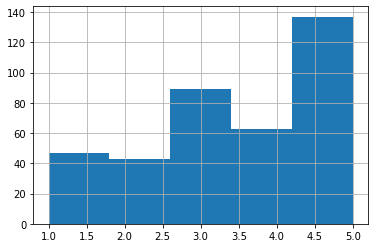

In [65]:
look_at('health',True) # текущее состояние здоровья 

In [66]:
sntmod('health')

Пропуски в столбце health заменены на моду 5.0  . После замены осталось пропусков : 0 


*Столбец **health**. Количество уникальных значений корректно.Со здоровьем у учащихся, вцелом, все в порядке.*

<h1><center><span style='color:red'>Cтолбец absences
</span></center></h1>

0        6.0
1        4.0
2       10.0
3        2.0
4        4.0
       ...  
390    212.0
391      3.0
392      3.0
393      0.0
394      5.0
Name: absences, Length: 394, dtype: float64

***------------------Описание absences --------------------------------------------------***


count    382.000000
mean       7.261780
std       23.493441
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

***------------------Краткая информация по absences -------------------------------------***


,absences
0.0,111
2.0,60
4.0,53
6.0,31
8.0,21
10.0,17
12.0,12
14.0,11
3.0,8
16.0,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  382 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


***------------------Пропуски в данных в absences ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
24,GP,F,15,R,GT3,T,2.0,4.0,services,health,course,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,-9.0,yes,yes,no,4.0,3.0,2.0,5.0,NaN,40.0
101,GP,M,16,U,GT3,T,4.0,4.0,services,teacher,other,father,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,4.0,NaN,85.0
120,GP,F,15,U,GT3,T,1.0,2.0,at_home,other,course,mother,1.0,2.0,0.0,no,no,no,no,no,-6.0,yes,yes,no,3.0,2.0,3.0,1.0,NaN,75.0
129,GP,M,16,R,GT3,T,4.0,4.0,teacher,teacher,course,mother,1.0,2.0,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0
150,GP,M,18,U,LE3,T,1.0,1.0,other,other,course,mother,1.0,1.0,3.0,no,no,no,no,yes,-3.0,no,yes,yes,2.0,3.0,5.0,4.0,NaN,0.0
172,GP,M,17,U,GT3,T,4.0,4.0,teacher,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,4.0,4.0,5.0,NaN,50.0
215,GP,F,17,U,LE3,T,3.0,2.0,other,other,reputation,mother,2.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,1.0,NaN,75.0
227,GP,M,17,U,LE3,T,2.0,3.0,services,services,reputation,father,1.0,2.0,0.0,no,yes,yes,no,no,NaN,yes,yes,no,5.0,3.0,3.0,3.0,NaN,60.0
254,GP,M,17,U,GT3,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0
265,GP,M,18,R,LE3,T,3.0,4.0,other,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,2.0,5.0,1.0,NaN,85.0


Количество пустых значений в столбце absences : 12



***--------------Определим наличие выбросов в данных с помощью IQR в absences -------***


25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].



***--------------Выбросы в absences вниз  -------------------------------------------***


В данных столбца absences выбросов вниз : 0



***--------------Выбросы в absences вверх  ------------------------------------------***


В данных столбца absences выбросов вверх : 17


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,yes,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,T,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,T,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,yes,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,other,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,T,4.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,yes,no,no,no,-6.0,no,yes,yes,4.0,1.0,1.0,5.0,75.0,45.0


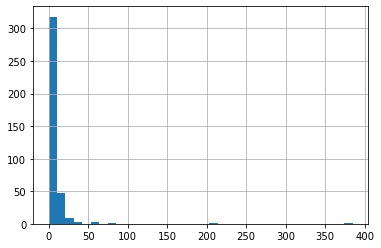

In [67]:
look_at('absences',True) # количество пропущенных занятий

In [68]:
sntmed('absences')

Пропуски в столбце absences заменены на значение медианы 4.0  . После замены осталось пропусков : 0 


In [69]:
#Заменяем выбросы вверх на медианное значение. Границу выбросов нашли с помощью IQR
soupmed('absences',20)

Выбросы вверх (больше 20) в столбце absences заменены на значение медианы 4.0 


*Столбец **absences**. Выбросы вверх заменили на медианное значение. Выбросов вниз нет.Распределение смещено вправо.* 

<h1><center><span style='color:red'>Cтолбец score
</span></center></h1>

0      30.0
1      30.0
2      50.0
3      75.0
4      50.0
       ... 
390    45.0
391    80.0
392    35.0
393    50.0
394    45.0
Name: score, Length: 394, dtype: float64

***------------------Описание score --------------------------------------------------***


count    388.000000
mean      52.293814
std       22.940126
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

***------------------Краткая информация по score -------------------------------------***


,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
60.0,31
40.0,30
70.0,27
45.0,27
80.0,16


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   388 non-null    float64
dtypes: float64(1)
memory usage: 16.2 KB


***------------------Пропуски в данных в score ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
201,GP,F,16,U,GT3,T,2.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,no,no,4.0,3.0,3.0,4.0,6.0,NaN
244,GP,F,18,U,GT3,T,2.0,1.0,other,other,course,other,2.0,3.0,0.0,no,yes,yes,no,no,-9.0,yes,yes,yes,4.0,4.0,4.0,3.0,0.0,NaN
270,GP,F,19,U,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,5.0,5.0,4.0,NaN
283,GP,F,18,U,GT3,T,1.0,1.0,other,other,home,mother,2.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,yes,no,5.0,3.0,4.0,4.0,4.0,NaN
312,GP,M,19,U,GT3,T,1.0,2.0,other,services,course,other,1.0,2.0,1.0,no,no,no,no,no,-6.0,yes,yes,no,4.0,5.0,3.0,4.0,3.0,NaN
350,MS,M,19,U,GT3,T,1.0,1.0,other,services,home,other,3.0,2.0,3.0,no,no,no,no,yes,-6.0,yes,yes,no,5.0,4.0,4.0,2.0,8.0,NaN


Количество пустых значений в столбце score : 6



***--------------Определим наличие выбросов в данных с помощью IQR в score -------***


25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].



***--------------Выбросы в score вниз  -------------------------------------------***


В данных столбца score выбросов вниз : 0



***--------------Выбросы в score вверх  ------------------------------------------***


В данных столбца score выбросов вверх : 0






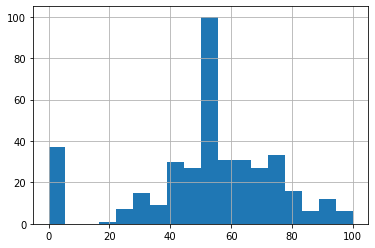

In [70]:
# Важный столбец, т.к. наша модель будет прогнозировать именно результат экзамена.
look_at('score',True) # баллы по госэкзамену по математике

In [71]:
sntmed('score')

Пропуски в столбце score заменены на значение медианы 55.0  . После замены осталось пропусков : 0 


*Столбец **score**. Согласно методу IQR выбросов в данных нет. Значение 0 - значит ученик экзамен не сдал. Судя по **score** -
минимальный балл для сдачи экзамена равен 20.*

<h1><center><span style='color:red'>Cтолбец studytime_gran
</span></center></h1>

0     -6.0
1     -6.0
2     -6.0
3     -9.0
4     -6.0
      ... 
390   -6.0
391   -3.0
392   -3.0
393   -3.0
394   -3.0
Name: studytime_gran, Length: 394, dtype: float64

***------------------Описание studytime_gran --------------------------------------------------***


count    387.000000
mean      -6.124031
std        2.524515
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime_gran, dtype: float64

***------------------Краткая информация по studytime_gran -------------------------------------***


,studytime_gran
-6.0,194
-3.0,102
-9.0,64
-12.0,27


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   studytime_gran  387 non-null    float64
dtypes: float64(1)
memory usage: 16.2 KB


***------------------Пропуски в данных в studytime_gran ---------------------------------------***


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
17,GP,F,16,U,GT3,T,3.0,3.0,other,other,reputation,mother,3.0,2.0,0.0,yes,yes,no,yes,yes,NaN,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
112,GP,F,16,U,GT3,T,2.0,2.0,at_home,other,course,mother,1.0,2.0,1.0,yes,no,no,yes,yes,NaN,yes,yes,no,3.0,1.0,2.0,5.0,6.0,65.0
129,GP,M,16,R,GT3,T,4.0,4.0,teacher,teacher,course,mother,1.0,2.0,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,4.0,90.0
227,GP,M,17,U,LE3,T,2.0,3.0,services,services,reputation,father,1.0,2.0,0.0,no,yes,yes,no,no,NaN,yes,yes,no,5.0,3.0,3.0,3.0,4.0,60.0
266,GP,M,17,U,GT3,T,3.0,1.0,services,other,other,mother,1.0,2.0,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,5.0,4.0,4.0,5.0,2.0,50.0
314,GP,F,19,U,GT3,T,1.0,1.0,at_home,health,home,other,1.0,2.0,2.0,no,no,no,no,no,NaN,yes,yes,yes,4.0,3.0,2.0,3.0,14.0,65.0


Количество пустых значений в столбце studytime_gran : 7



***--------------Определим наличие выбросов в данных с помощью IQR в studytime_gran -------***


25-й перцентиль: -6.0, 75-й перцентиль: -3.0, IQR: 3.0,  Границы выбросов: [-10.5, 1.5].



***--------------Выбросы в studytime_gran вниз  -------------------------------------------***


В данных столбца studytime_gran выбросов вниз : 27


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
47,GP,M,16,U,GT3,T,4.0,3.0,health,other,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0
66,GP,M,15,U,GT3,A,4.0,4.0,other,services,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,no,-12.0,yes,yes,yes,1.0,3.0,3.0,3.0,4.0,60.0
67,GP,F,16,U,GT3,T,3.0,2.0,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,3.0,5.0,4.0,30.0
69,GP,F,15,R,LE3,T,3.0,1.0,other,other,reputation,father,2.0,4.0,0.0,no,yes,no,no,no,-12.0,yes,yes,no,4.0,4.0,2.0,3.0,12.0,80.0
70,GP,M,16,U,GT3,T,3.0,1.0,other,other,reputation,father,1.0,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
71,GP,M,15,U,GT3,T,4.0,2.0,other,other,course,mother,1.0,4.0,0.0,no,no,no,no,yes,-12.0,yes,yes,no,3.0,3.0,3.0,3.0,0.0,50.0
76,GP,M,15,U,GT3,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,course,mother,1.0,4.0,0.0,no,no,yes,no,yes,-12.0,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0
94,GP,M,15,U,LE3,T,2.0,2.0,services,health,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,yes,-12.0,yes,yes,no,4.0,3.0,4.0,4.0,6.0,70.0
95,GP,F,15,R,GT3,T,1.0,1.0,at_home,other,home,mother,2.0,4.0,1.0,yes,yes,yes,yes,yes,-12.0,yes,yes,no,3.0,1.0,2.0,1.0,2.0,50.0



***--------------Выбросы в studytime_gran вверх  ------------------------------------------***


В данных столбца studytime_gran выбросов вверх : 0






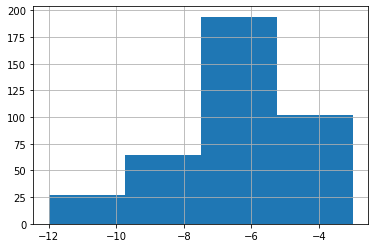

In [72]:
look_at('studytime_gran',True)

In [73]:
# В столбце studytime_gran видим 4-ре дискретных значения. Непонятно, что описывает этот столбец (в задании он не упомянут), 
# однако, если значения дискретные, то заменим отсутствующие данные но моду.
sntmod('studytime_gran')

Пропуски в столбце studytime_gran заменены на моду -6.0  . После замены осталось пропусков : 0 


*Столбец **studytime_gran**. Пустые значения заменены на моду. Значения, равные -12, которые определаются по методу IQR как 
выбросы отбрасывать не будем, они укладываются в логику дискретных значений столбца (-3,-6,-9,-12).*

In [74]:
s_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   school          394 non-null    object 
 1   sex             394 non-null    object 
 2   age             394 non-null    int64  
 3   address         394 non-null    object 
 4   famsize         394 non-null    object 
 5   pstatus         394 non-null    object 
 6   medu            394 non-null    float64
 7   fedu            394 non-null    float64
 8   mjob            394 non-null    object 
 9   fjob            394 non-null    object 
 10  reason          394 non-null    object 
 11  guardian        394 non-null    object 
 12  traveltime      394 non-null    float64
 13  studytime       394 non-null    float64
 14  failures        394 non-null    float64
 15  schoolsup       394 non-null    object 
 16  famsup          394 non-null    object 
 17  paid            394 non-null    obj

*Пропуски в данных отсутствуют*

In [75]:
# ДАННЫЕ ПОДГОТОВЛЕНЫ . НАЧИНАЕМ КОРРЕЛЯЦИОНННЫЙ АНАЛИЗ

*Метрическими переменными в нашем наборе данных являются 'age','absences','score'*

In [76]:
metric_list=['age','absences','score']

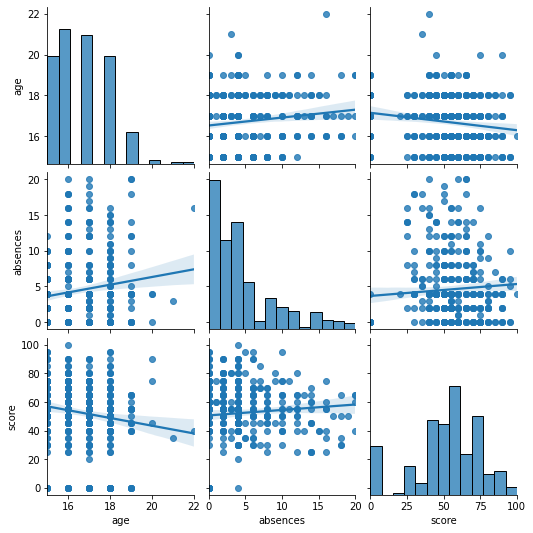

In [77]:
sns.pairplot(s_m.loc[:,metric_list], kind = 'reg')

In [78]:
s_m.loc[:,metric_list].corr()

,age,absences,score
age,1.000000,0.144579,-0.152015
absences,0.144579,1.000000,0.079817
score,-0.152015,0.079817,1.000000


*Положительная корреляция мажду **age** и **absence** может означать, что с увеличением возраста ученики пропускают 
больше уроков математики, а отрицательная между **age** и **score** , что старше ученик, тем успешнее он сдает экзамен.*

In [79]:
# Посмотрим, на проверки избыточности данных останльные номинативные переменные заданные цифрами :
s_m.corr()

,age,medu,fedu,traveltime,studytime,failures,studytime_gran,famrel,freetime,goout,health,absences,score
age,1.000000,-0.161896,-0.155517,0.083991,-0.017122,0.232975,0.017122,0.061483,0.024767,0.132901,-0.059202,0.144579,-0.152015
medu,-0.161896,1.000000,0.586867,-0.165514,0.071605,-0.241549,-0.071605,-0.019602,0.027077,0.060770,-0.064753,0.064740,0.196036
fedu,-0.155517,0.586867,1.000000,-0.121417,0.006321,-0.259841,-0.006321,-0.028433,-0.031393,0.037979,-0.008699,-0.025525,0.122091
traveltime,0.083991,-0.165514,-0.121417,1.000000,-0.096773,0.053599,0.096773,-0.024574,-0.014441,0.050335,-0.042856,-0.033209,-0.056116
studytime,-0.017122,0.071605,0.006321,-0.096773,1.000000,-0.160687,-1.000000,0.027403,-0.123456,-0.054428,-0.061864,-0.068888,0.112924
failures,0.232975,-0.241549,-0.259841,0.053599,-0.160687,1.000000,0.160687,0.002722,0.103093,0.120511,0.067090,0.068478,-0.325694
studytime_gran,0.017122,-0.071605,-0.006321,0.096773,-1.000000,0.160687,1.000000,-0.027403,0.123456,0.054428,0.061864,0.068888,-0.112924
famrel,0.061483,-0.019602,-0.028433,-0.024574,0.027403,0.002722,-0.027403,1.000000,0.157192,0.066687,0.100480,-0.065376,0.049605
freetime,0.024767,0.027077,-0.031393,-0.014441,-0.123456,0.103093,0.123456,0.157192,1.000000,0.290073,0.067734,0.093631,0.016519
goout,0.132901,0.060770,0.037979,0.050335,-0.054428,0.120511,0.054428,0.066687,0.290073,1.000000,-0.010742,0.109037,-0.127293


*Все эти переменные не скоррелированны настолько, чтобы можно было удалить что-то.*

## Номинативные переменные

In [80]:
s_m.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
       'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_gran', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [81]:
nom_list=['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
       'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_gran', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences']

2


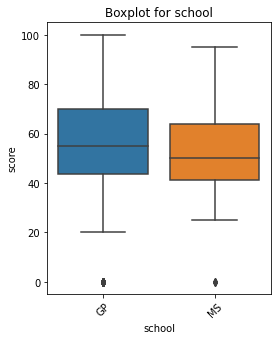

2


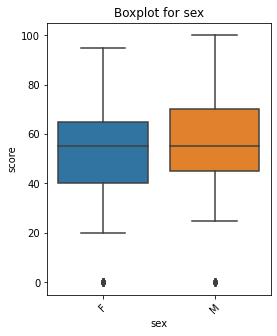

8


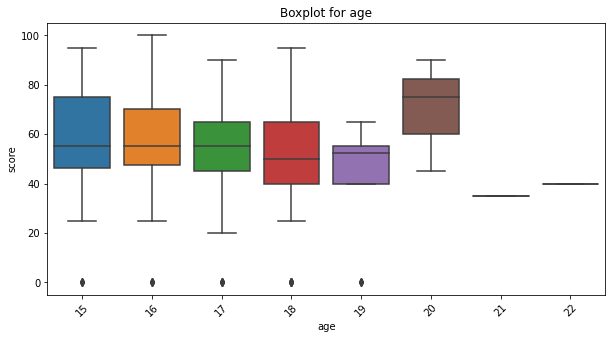

2


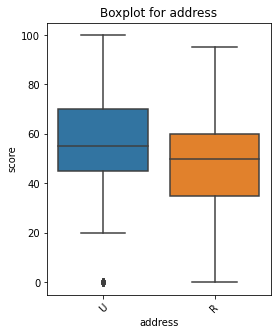

2


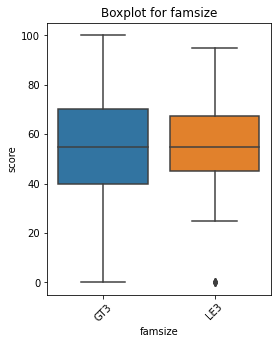

2


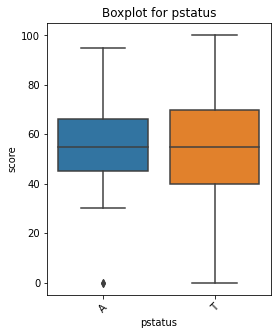

5


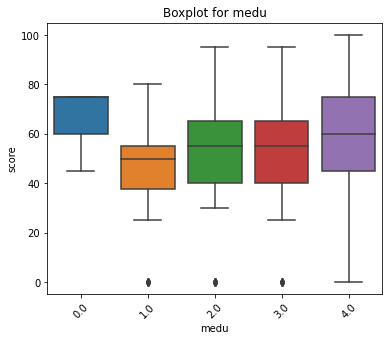

5


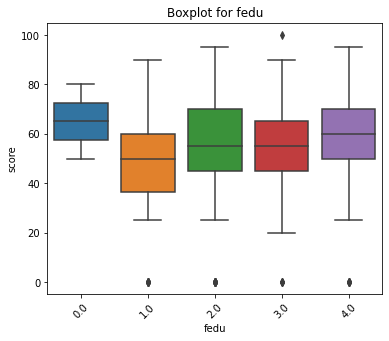

5


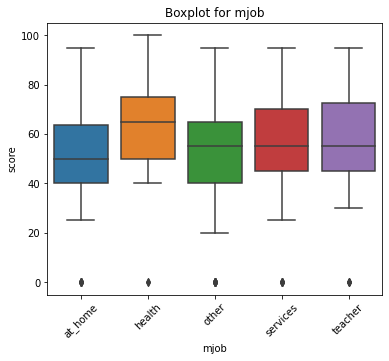

5


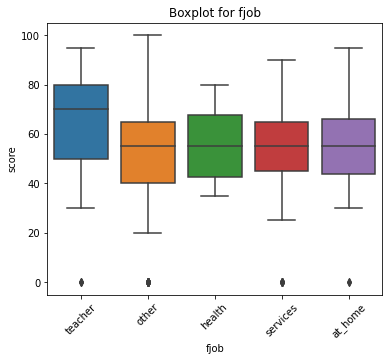

4


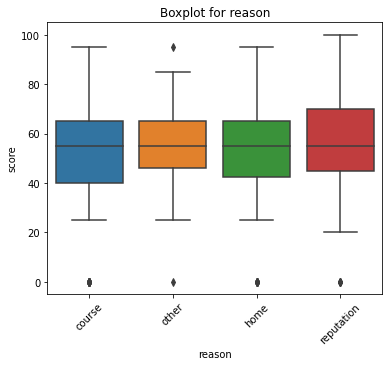

3


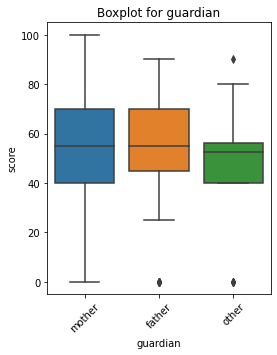

4


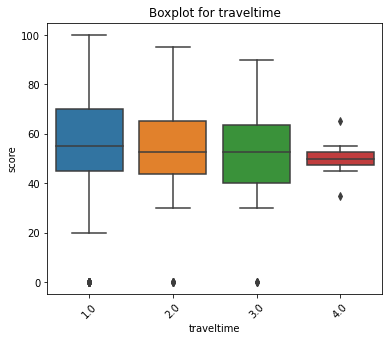

4


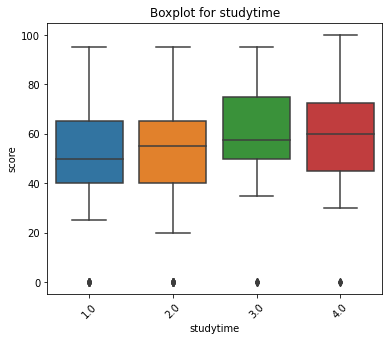

4


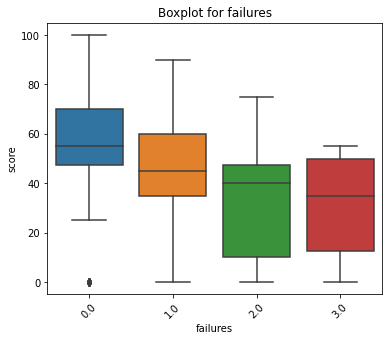

2


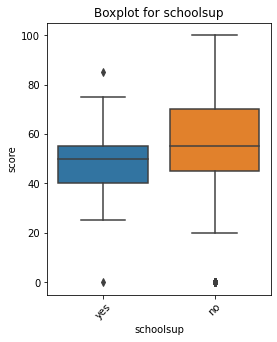

2


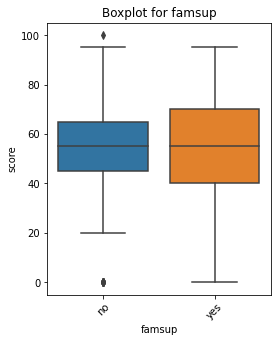

2


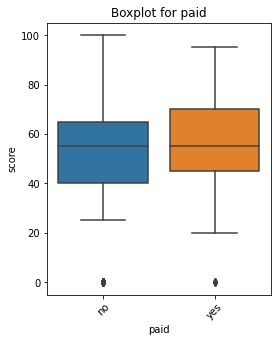

2


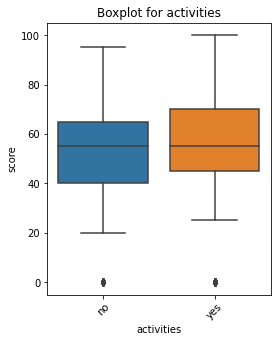

2


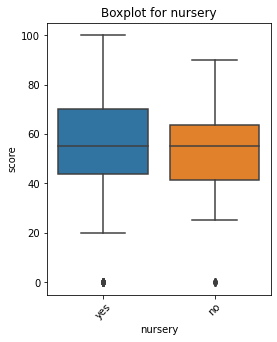

4


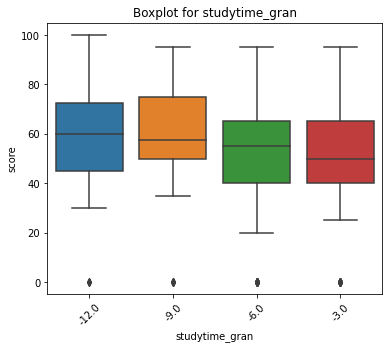

2


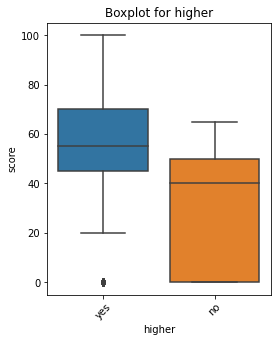

2


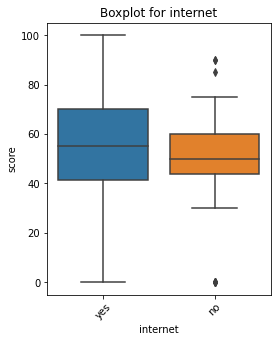

2


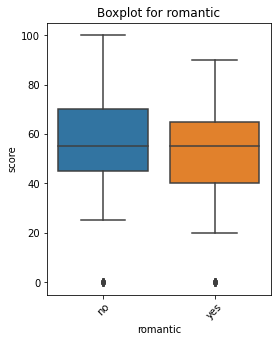

5


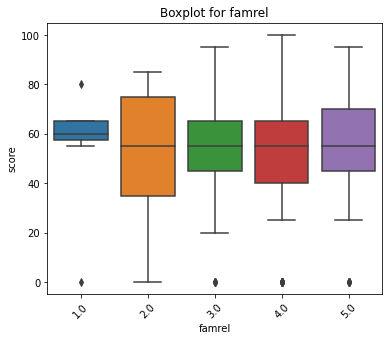

5


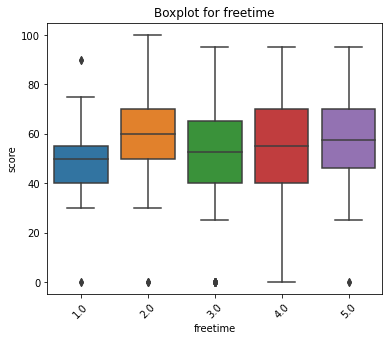

5


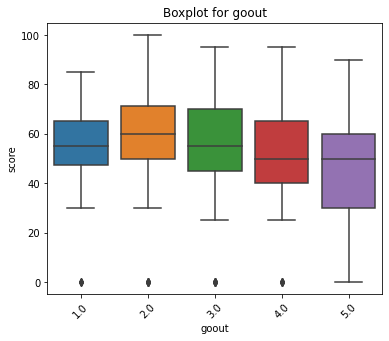

5


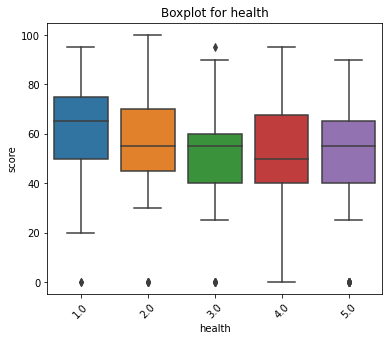

21


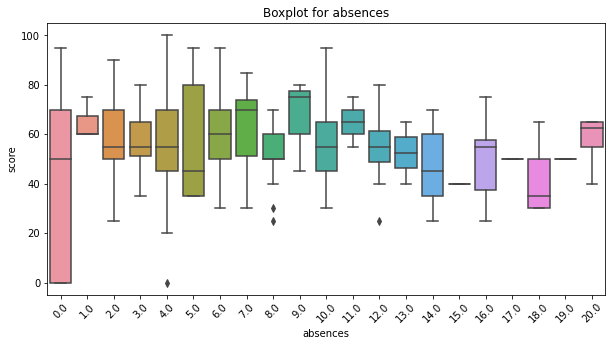

In [82]:
for col in nom_list:
    get_boxplot(col)

In [85]:
# Проверим, есть ли статистическая разница в распределении количества баллов по номинативным признакам, 
# с помощью теста Стьюдента.
# Проверим нулевую гипотезу о том, что распределения количества баллов на экзамене по математике 
# по различным параметрам неразличимы:

for col in nom_list:
    get_stat_dif(col)

Тест Стьюдента дла school закончен .
Тест Стьюдента дла sex закончен .
Тест Стьюдента дла age закончен .


**Найдены статистически значимые различия для колонки address**

Тест Стьюдента дла famsize закончен .
Тест Стьюдента дла pstatus закончен .


**Найдены статистически значимые различия для колонки medu**

Тест Стьюдента дла fedu закончен .


**Найдены статистически значимые различия для колонки mjob**

Тест Стьюдента дла fjob закончен .
Тест Стьюдента дла reason закончен .
Тест Стьюдента дла guardian закончен .
Тест Стьюдента дла traveltime закончен .
Тест Стьюдента дла studytime закончен .


**Найдены статистически значимые различия для колонки failures**

Тест Стьюдента дла schoolsup закончен .
Тест Стьюдента дла famsup закончен .
Тест Стьюдента дла paid закончен .
Тест Стьюдента дла activities закончен .
Тест Стьюдента дла nursery закончен .
Тест Стьюдента дла studytime_gran закончен .


**Найдены статистически значимые различия для колонки higher**

Тест Стьюдента дла internet закончен .


**Найдены статистически значимые различия для колонки romantic**

Тест Стьюдента дла famrel закончен .
Тест Стьюдента дла freetime закончен .
Тест Стьюдента дла goout закончен .
Тест Стьюдента дла health закончен .
Тест Стьюдента дла absences закончен .


In [84]:
# С помощью теста Стьюдента определили переменные датасета для построения модели : 
list_for_model={'address','medu','mjob','failures','higher','romantic','age','absences','score'}
s_m_for_model=s_m.loc[:,list_for_model]
s_m_for_model.head()

,absences,score,romantic,higher,age,medu,address,failures,mjob
0,6.0,30.0,no,yes,18,4.0,U,0.0,at_home
1,4.0,30.0,no,yes,17,1.0,U,0.0,at_home
2,10.0,50.0,no,yes,15,1.0,U,3.0,at_home
3,2.0,75.0,yes,yes,15,4.0,U,0.0,health
4,4.0,50.0,no,yes,16,3.0,U,0.0,other


В результате EDA для анализа влияния социально-бытовых условий учеников на количество баллов, набранных на экзамене по математике были получены следующие выводы:

В данных достаточно много пропусков, только в столбцах school(аббревиатура школы, в которой учится ученик ),sex(пол ученика) и age(возраст ученика) не было пропусков данных. В остальных случаях пропуски заменялись на моду, в случае номинативных и на медианное значение, в случае метрических переменных.
Выбросов, требующих коррекции данных, было немного. 
В столбце fedu(образование отца) – выброс вверх - явная опечатка. 
В столбце famrel(семейные отношения) – выброс вниз удален.
В столбцах ранговых переменных fedu(образование отца), traveltime(время в пути до школы), studytime (время на учёбу помимо школы в неделю),
failures (количество внеучебных неудач), famrel(семейные отношения),
freetime(свободное время после школы), goout(проведение времени с друзьями), health(текущее состояние здоровья) используются цифровые значения. В таких столбцах значения,которые методом IQR определяются как выбросы, входили в диапазон корректных значений. В таких столбцах мы не изменяли данные.
Положительная корреляция мажду age и absence может означать, что с увеличением возраста ученики пропускают больше уроков математики, а отрицательная между age и score , что старше ученик, тем успешнее он сдает экзамен.
Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это address,medu,mjob,failures,higher,romantic,age и absences.
